In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import xlrd

workbook_name = 'CH9_reservoir prop.xlsx'
#importing data box
Nx = 12
Ny = 9
Nz = 1 #This is 2D problem (Nz = 1)
t = 20
dt = 1 #days

# reservoir properties
pi = 4800# 7750
p_ref = 14.7
cr = 3e-6
calpha = 5.6146
cbeta = 1.127e-3
Z_datum = 9300

#array matrix for reservoir properties
dx = np.zeros((Nz,Ny,Nx))
dy = np.zeros((Nz,Ny,Nx))
kx = np.zeros((Nz,Ny,Nx))
ky = np.zeros((Nz,Ny,Nx))
kz = np.zeros((Nz,Ny,Nx))
Ax = np.zeros((Nz,Ny,Nx))
Ay = np.zeros((Nz,Ny,Nx))
Az = np.zeros((Nz,Ny,Nx))
phi = np.zeros((Nz,Ny,Nx))
phi_ref = np.zeros((Nz,Ny,Nx))
dz = np.zeros((Nz,Ny,Nx))
top = np.zeros((Nz,Ny,Nx))
bottom = np.zeros((Nz,Ny,Nx))
middle = np.zeros((Nz,Ny,Nx))
null = np.zeros((Nz,Ny,Nx))
null_im = []

po = np.zeros((Nz,Ny,Nx))
# po_new = np.zeros((Nz,Ny,Nx))
po_inner = np.zeros((Nz,Ny,Nx))

q_switch = np.zeros((Nz,Ny,Nx))
qosc = np.zeros((Nz,Ny,Nx))
qwsc = np.zeros((Nz,Ny,Nx))
qgsc = np.zeros((Nz,Ny,Nx))

pwf = np.zeros((Nz,Ny,Nx))
Jo = np.zeros((Nz,Ny,Nx))
Jw = np.zeros((Nz,Ny,Nx))
Jg = np.zeros((Nz,Ny,Nx))
Jw_switch = np.zeros((Nz,Ny,Nx))
rw = np.zeros((Nz,Ny,Nx))

#multiphase flow parameter
Sw = np.zeros((Nz,Ny,Nx))
Sw_inner = np.zeros((Nz,Ny,Nx))
# Sw_new = np.zeros((Nz,Ny,Nx))

Sg = np.zeros((Nz,Ny,Nx))
Sg_inner = np.zeros((Nz,Ny,Nx))
# Sg_new = np.zeros((Nz,Ny,Nx))

Bo = np.zeros((Nz,Ny,Nx))
Bw = np.zeros((Nz,Ny,Nx))
Bg = np.zeros((Nz,Ny,Nx))
Rs = np.zeros((Nz,Ny,Nx))
visco = np.zeros((Nz,Ny,Nx))
viscw = np.zeros((Nz,Ny,Nx))
viscg = np.zeros((Nz,Ny,Nx))


pcow = np.zeros((Nz,Ny,Nx))
pcow_inner = np.zeros((Nz,Ny,Nx))
pcgo = np.zeros((Nz,Ny,Nx))
pcgo_inner = np.zeros((Nz,Ny,Nx))

In [2]:
import xlrd

#initialization
res_Excel = xlrd.open_workbook(workbook_name)

for ix in range (0,Nx):
    for iy in range(0,Ny):       
        for iz in range(0,Nz):
            dx[:,iy,ix] = res_Excel.sheet_by_name('dx').cell(iy,ix).value
            dy[:,iy,ix] = res_Excel.sheet_by_name('dy').cell(iy,ix).value

            if iz == 0:

                kx[iz,iy,ix] = res_Excel.sheet_by_name('kx1').cell(iy,ix).value
                ky[iz,iy,ix] = res_Excel.sheet_by_name('ky1').cell(iy,ix).value
                kz[iz,iy,ix] = res_Excel.sheet_by_name('kz1').cell(iy,ix).value
                phi[iz,iy,ix] = res_Excel.sheet_by_name('phi1').cell(iy,ix).value
                phi_ref[iz,iy,ix] = res_Excel.sheet_by_name('phi1').cell(iy,ix).value
                top[iz,iy,ix] = res_Excel.sheet_by_name('T1').cell(iy,ix).value
                bottom[iz,iy,ix] = res_Excel.sheet_by_name('B1').cell(iy,ix).value
                null[iz,iy,ix] = res_Excel.sheet_by_name('null1').cell(iy,ix).value

                
            dz[iz,iy,ix] = bottom[iz,iy,ix]-top[iz,iy,ix]
            middle[iz,iy,ix] = (top[iz,iy,ix] + bottom[iz,iy,ix])/2
            Ax[iz,iy,ix] = dy[iz,iy,ix]*dz[iz,iy,ix]
            Ay[iz,iy,ix] = dx[iz,iy,ix]*dz[iz,iy,ix]
            Az[iz,iy,ix] = dx[iz,iy,ix]*dy[iz,iy,ix]

#             if null[iz,iy,ix] == 1:
#                 #pressure distribution (initialization)
#                 po[iz,iy,ix] = pressure_initializer(middle[iz,iy,ix],pi,Z_datum)
            
#print(p)

In [3]:
#PVT Property generator (by interpolation from PVT table)

import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # plotting
from scipy.interpolate import interp1d as interp

PVT_csv = pd.read_csv("PVT CH9.csv")

Bw_func = interp(PVT_csv['Pressure'].values,PVT_csv['Bw'].values, kind = 'linear')
Bo_func = interp(PVT_csv['Pressure'].values,PVT_csv['Bo'].values, kind = 'linear')
Bg_func = interp(PVT_csv['Pressure'].values,PVT_csv['Bg'].values, kind = 'linear')
rhow_func = interp(PVT_csv['Pressure'].values,PVT_csv['rhow'].values, kind = 'linear')
rhoo_func = interp(PVT_csv['Pressure'].values,PVT_csv['rhoo'].values, kind = 'linear')
rhog_func = interp(PVT_csv['Pressure'].values,PVT_csv['rhog'].values, kind = 'linear')
viscw_func = interp(PVT_csv['Pressure'].values,PVT_csv['viscw'].values, kind = 'linear')
visco_func = interp(PVT_csv['Pressure'].values,PVT_csv['visco'].values, kind = 'linear')
viscg_func = interp(PVT_csv['Pressure'].values,PVT_csv['viscg'].values, kind = 'linear')
Rs_func = interp(PVT_csv['Pressure'].values,PVT_csv['Rs'].values, kind = 'linear')
zg_func = interp(PVT_csv['Pressure'].values,PVT_csv['zg'].values, kind = 'linear')

def co_func(p):
    #definition for above bubble point (for convinient): dRs_dp is called in the separated function
    dp = 1
    rhoo_left1 = rhoo_func(p-dp);  rhoo_center = rhoo_func(p);  rhoo_right1 = rhoo_func(p+dp)
    drhoo_dp = (rhoo_right1-rhoo_left1)/2/dp
    return 1/rhoo_center*drhoo_dp

def cw_func(p):
    dp = 1
    rhow_left1 = rhow_func(p-dp);  rhow_center = rhow_func(p);  rhow_right1 = rhow_func(p+dp)
    drhow_dp = (rhow_right1-rhow_left1)/2/dp
    return 1/rhow_center*drhow_dp

def cg_func(p):
    dp = 1
    rhog_left1 = rhog_func(p-dp);  rhog_center = rhog_func(p);  rhog_right1 = rhog_func(p+dp)
    drhog_dp = (rhog_right1-rhog_left1)/2/dp
    return 1/rhog_center*drhog_dp

def dRs_dp_func(p):
    dp = 1
    Rs_left1 = Rs_func(p-dp);  Rs_center = Rs_func(p);  Rs_right1 = Rs_func(p+dp)
    dRs_dp = (Rs_right1-Rs_left1)/2/dp
    return dRs_dp


def cal_phi(p,p_ref,phi_ref,cr):
    return phi_ref*(1+cr*(p-p_ref))

def cr_func(p,p_ref,phi_ref,cr):
    dp = 1
    phi_left1 = cal_phi(p-dp,p_ref,phi_ref,cr);  phi_center = cal_phi(p,p_ref,phi_ref,cr);  phi_right1 = cal_phi(p+dp,p_ref,phi_ref,cr)
    dphi_dp = (phi_right1-phi_left1)/2/dp
    return 1/phi_center*dphi_dp

In [4]:
#Subroutine for kr + Pc

#relative permeability (kr)
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import xlrd
from scipy.interpolate import interp1d as interp

workbook_name = 'kr_Pc CH9.xlsx'
kr_Excel = xlrd.open_workbook(workbook_name)

Nkrw = 25
Sw_array_for_kr = np.zeros(Nkrw)
krw_array_for_kr = np.zeros(Nkrw)
krow_array_for_kr = np.zeros(Nkrw)


for i in range(0,Nkrw):
    Sw_array_for_kr[i] = kr_Excel.sheet_by_name('krw').cell(i,0).value
    krw_array_for_kr[i] = kr_Excel.sheet_by_name('krw').cell(i,1).value
    krow_array_for_kr[i] = kr_Excel.sheet_by_name('krw').cell(i,2).value

krocw = np.max(krow_array_for_kr)
print('krocw = '+str(krocw))
Swc = np.min(Sw_array_for_kr)
print('Swc   = '+str(Swc))
Sorw = np.max(Sw_array_for_kr)
print('Sorw  = '+str(Sorw))

Nkrg = 19
Sg_array_for_kr = np.zeros(Nkrg)
krg_array_for_kr = np.zeros(Nkrg)
krog_array_for_kr = np.zeros(Nkrg)

for i in range(0,Nkrg):
    Sg_array_for_kr[i] = kr_Excel.sheet_by_name('krg').cell(i,0).value
    krg_array_for_kr[i] = kr_Excel.sheet_by_name('krg').cell(i,1).value
    krog_array_for_kr[i] = kr_Excel.sheet_by_name('krg').cell(i,2).value

krocg = np.max(krog_array_for_kr)
print('krocg = '+str(krocg))
Sgc = np.min(Sg_array_for_kr)
print('Sgc   = '+str(Sgc))
Sorg = np.max(Sg_array_for_kr)
print('Sorg  = '+str(Sorg))

krw_func = interp(Sw_array_for_kr,krw_array_for_kr,kind = 'quadratic')
krow_func = interp(Sw_array_for_kr,krow_array_for_kr,kind = 'quadratic')
krg_func = interp(Sg_array_for_kr,krg_array_for_kr,kind = 'quadratic')
krog_func = interp(Sg_array_for_kr,krog_array_for_kr,kind = 'quadratic')

def kro_func(Sw_loc,Sg_loc):
    krw_loc = krw_func(Sw_loc)
    krg_loc = krg_func(Sg_loc)
    krow_loc = krow_func(Sw_loc)
    krog_loc = krog_func(Sg_loc)
    kro_loc = (krow_loc/krocw + krw_loc)*(krog_loc/krocg + krg_loc) - (krw_loc + krg_loc)
    if(kro_loc < 0):
        kro_loc = 0
    return kro_loc



#Capillary Pressure (Pc)
#oil-water
NPcow = 9
Sw_array_for_Pc = np.zeros(NPcow)
Pcow_array_for_Pc = np.zeros(NPcow)

for i in range(0,NPcow):
    Sw_array_for_Pc[i] = kr_Excel.sheet_by_name('Pcow').cell(i,0).value
    Pcow_array_for_Pc[i] = kr_Excel.sheet_by_name('Pcow').cell(i,1).value

Pcow_func = interp(Sw_array_for_Pc,Pcow_array_for_Pc,kind = 'quadratic')

#gas-oil
NPcgo = 8
Sg_array_for_Pc = np.zeros(NPcgo)
Pcgo_array_for_Pc = np.zeros(NPcgo)

for i in range(0,NPcgo):
    Sg_array_for_Pc[i] = 1 - kr_Excel.sheet_by_name('Pcgo').cell(i,0).value
    Pcgo_array_for_Pc[i] = kr_Excel.sheet_by_name('Pcgo').cell(i,1).value

Sg_array_for_Pc.sort()
Pcgo_array_for_Pc.sort()

Pcgo_func = interp(Sg_array_for_Pc,Pcgo_array_for_Pc,kind = 'quadratic')

krocw = 1.0
Swc   = 0.18
Sorw  = 0.9
krocg = 1.0
Sgc   = 0.0
Sorg  = 0.72


In [5]:
def check_flow_dir(pN,pM,rhoN,rhoM,ZN,ZM):
    potential = (pM-pN) - (rhoM + rhoN)/2/144 *(ZM-ZN)
#     print('potential'); print(potential)
#     print('ZM'); print(ZM)
#     print('ZN'); print(ZN)
#     print('pM'); print(pM)
#     print('pN'); print(pN)
    
    if potential < 0:
        return 'N'
    else:
        return 'M'
    
#transmissibility calculator
#[0] = Tl,  [1] = Tl*gamma  [2] = Tl*Rs (for oil only)

def trans_W_cal(iz,iy,ix,phase):
#for (i-1,j,k) grid bock (W-direction)
    if (ix == 0) or (null[iz,iy,ix]==0):
        return 0, 0, 0, 0
    elif (null[iz,iy,ix-1]==0):
        return 0, 0, 0, 0
    else:
        po_C = po[iz,iy,ix];  Sw_C = Sw[iz,iy,ix];  Sg_C = Sg[iz,iy,ix];  Z_C = middle[iz,iy,ix]

        po_W = po[iz,iy,ix-1];  Sw_W = Sw[iz,iy,ix-1];  Sg_W = Sg[iz,iy,ix-1];  Z_W = middle[iz,iy,ix-1]
        
        #upstream_block = check_flow_dir(po_C,po_W,rhoo_C,rhoo_W,Z_C,Z_W)
        ##print(upstream_block)
        
        if phase == 'oil':
            visco_C = visco_func(po_C);  Bo_C = Bo_func(po_C);  rhoo_C = rhoo_func(po_C); Rs_C = Rs_func(po_C);
            visco_W = visco_func(po_W);  Bo_W = Bo_func(po_W);  rhoo_W = rhoo_func(po_W); Rs_W = Rs_func(po_W);
            tran_W_Gterm = cbeta*2/(dx[iz,iy,ix-1]/Ax[iz,iy,ix-1]/kx[iz,iy,ix-1]+dx[iz,iy,ix]/Ax[iz,iy,ix]/kx[iz,iy,ix])
            tran_W_Fterm = 1/(visco_W+visco_C)*2/(Bo_W+Bo_C)*2
            
            upstream_block = check_flow_dir(po_C,po_W,rhoo_C,rhoo_W,Z_C,Z_W)
            #print(upstream_block)
        
            if upstream_block == 'N':
                tran_W_Sterm = kro_func(Sw_C,Sg_C)
            else:
                tran_W_Sterm = kro_func(Sw_W,Sg_W)
                
            
            tran_W = tran_W_Gterm * tran_W_Fterm * tran_W_Sterm
            tran_W_grav = tran_W_Gterm * tran_W_Fterm * tran_W_Sterm * (rhoo_C + rhoo_W)/2/144
            tran_W_Rs = tran_W_Gterm * tran_W_Fterm * tran_W_Sterm * (Rs_C + Rs_W)/2
            tran_W_Rs_grav = tran_W_Gterm * tran_W_Fterm * tran_W_Sterm * (Rs_C + Rs_W)/2 * (rhoo_C + rhoo_W)/2/144
            
            return tran_W, tran_W_grav, tran_W_Rs,  tran_W_Rs_grav 
                
        if phase == 'water':
            viscw_C = viscw_func(po_C);  Bw_C = Bw_func(po_C);  rhow_C = rhow_func(po_C);
            viscw_W = viscw_func(po_W);  Bw_W = Bw_func(po_W);  rhow_W = rhow_func(po_W)
            tran_W_Gterm = cbeta*2/(dx[iz,iy,ix-1]/Ax[iz,iy,ix-1]/kx[iz,iy,ix-1]+dx[iz,iy,ix]/Ax[iz,iy,ix]/kx[iz,iy,ix])
            tran_W_Fterm = 1/(viscw_W+viscw_C)*2/(Bw_W+Bw_C)*2

            upstream_block = check_flow_dir(po_C - Pcow_func(Sw_C),po_W - Pcow_func(Sw_W),rhow_C,rhow_W,Z_C,Z_W)
            #print(upstream_block)
            
            if upstream_block == 'N':
                tran_W_Sterm = krw_func(Sw_C)
            else:
                tran_W_Sterm = krw_func(Sw_W)
            
            tran_W = tran_W_Gterm * tran_W_Fterm * tran_W_Sterm
            tran_W_grav = tran_W_Gterm * tran_W_Fterm * tran_W_Sterm * (rhow_C + rhow_W)/2/144
            return tran_W, tran_W_grav
                
        if phase == 'gas':
            viscg_C = viscg_func(po_C);  Bg_C = Bg_func(po_C);  rhog_C = rhog_func(po_C);
            viscg_W = viscg_func(po_W);  Bg_W = Bg_func(po_W);  rhog_W = rhog_func(po_W)
            tran_W_Gterm = cbeta*2/(dx[iz,iy,ix-1]/Ax[iz,iy,ix-1]/kx[iz,iy,ix-1]+dx[iz,iy,ix]/Ax[iz,iy,ix]/kx[iz,iy,ix])
            tran_W_Fterm = 1/(viscg_W+viscg_C)*2/(Bg_W+Bg_C)*2

            upstream_block = check_flow_dir(po_C + Pcgo_func(Sg_C),po_W + Pcgo_func(Sg_W),rhog_C,rhog_W,Z_C,Z_W)
            #print(upstream_block)
            
            if upstream_block == 'N':
                tran_W_Sterm = krg_func(Sg_C)
            else:
                tran_W_Sterm = krg_func(Sg_W)
            
            tran_W = tran_W_Gterm * tran_W_Fterm * tran_W_Sterm
            tran_W_grav = tran_W_Gterm * tran_W_Fterm * tran_W_Sterm * (rhog_C + rhog_W)/2/144
            return tran_W, tran_W_grav
            
#         #print(upstream_block)

In [6]:
def trans_E_cal(iz,iy,ix,phase):
#for (i+1,j,k) grid bock (E-direction)
    if (ix == Nx-1) or (null[iz,iy,ix]==0):
        return 0, 0, 0, 0
    elif (null[iz,iy,ix+1]==0):
        return 0, 0, 0, 0
    
    else:
        po_C = po[iz,iy,ix];  Sw_C = Sw[iz,iy,ix];  Sg_C = Sg[iz,iy,ix];  Z_C = middle[iz,iy,ix]

        po_E = po[iz,iy,ix+1];  Sw_E = Sw[iz,iy,ix+1];  Sg_E = Sg[iz,iy,ix+1];  Z_E = middle[iz,iy,ix+1]
        
        #upstream_block = check_flow_dir(po_C,po_E,rhoo_C,rhoo_E,Z_C,Z_E)
        ##print(upstream_block)
        
        if phase == 'oil':
            visco_C = visco_func(po_C);  Bo_C = Bo_func(po_C);  rhoo_C = rhoo_func(po_C); Rs_C = Rs_func(po_C);
            visco_E = visco_func(po_E);  Bo_E = Bo_func(po_E);  rhoo_E = rhoo_func(po_E); Rs_E = Rs_func(po_E);
            tran_E_Gterm = cbeta*2/(dx[iz,iy,ix+1]/Ax[iz,iy,ix+1]/kx[iz,iy,ix+1]+dx[iz,iy,ix]/Ax[iz,iy,ix]/kx[iz,iy,ix])
            tran_E_Fterm = 1/(visco_E+visco_C)*2/(Bo_E+Bo_C)*2
            
            upstream_block = check_flow_dir(po_C,po_E,rhoo_C,rhoo_E,Z_C,Z_E)
            #print(upstream_block)
        
            if upstream_block == 'N':
                tran_E_Sterm = kro_func(Sw_C,Sg_C)
            else:
                tran_E_Sterm = kro_func(Sw_E,Sg_E)
                
            
            tran_E = tran_E_Gterm * tran_E_Fterm * tran_E_Sterm
            tran_E_grav = tran_E_Gterm * tran_E_Fterm * tran_E_Sterm * (rhoo_C + rhoo_E)/2/144
            tran_E_Rs = tran_E_Gterm * tran_E_Fterm * tran_E_Sterm * (Rs_C + Rs_E)/2
            tran_E_Rs_grav = tran_E_Gterm * tran_E_Fterm * tran_E_Sterm * (Rs_C + Rs_E)/2 * (rhoo_C + rhoo_E)/2/144
            
            
            return tran_E, tran_E_grav, tran_E_Rs, tran_E_Rs_grav
                
        if phase == 'water':
            viscw_C = viscw_func(po_C);  Bw_C = Bw_func(po_C);  rhow_C = rhow_func(po_C);
            viscw_E = viscw_func(po_E);  Bw_E = Bw_func(po_E);  rhow_E = rhow_func(po_E)
            tran_E_Gterm = cbeta*2/(dx[iz,iy,ix+1]/Ax[iz,iy,ix+1]/kx[iz,iy,ix+1]+dx[iz,iy,ix]/Ax[iz,iy,ix]/kx[iz,iy,ix])
            tran_E_Fterm = 1/(viscw_E+viscw_C)*2/(Bw_E+Bw_C)*2

            upstream_block = check_flow_dir(po_C - Pcow_func(Sw_C),po_E - Pcow_func(Sw_E),rhow_C,rhow_E,Z_C,Z_E)
            #print(upstream_block)
            
            if upstream_block == 'N':
                tran_E_Sterm = krw_func(Sw_C)
            else:
                tran_E_Sterm = krw_func(Sw_E)
            
            
            tran_E = tran_E_Gterm * tran_E_Fterm * tran_E_Sterm
            tran_E_grav = tran_E_Gterm * tran_E_Fterm * tran_E_Sterm * (rhow_C + rhow_E)/2/144
            
            return tran_E, tran_E_grav
                
        if phase == 'gas':
            viscg_C = viscg_func(po_C);  Bg_C = Bg_func(po_C);  rhog_C = rhog_func(po_C);
            viscg_E = viscg_func(po_E);  Bg_E = Bg_func(po_E);  rhog_E = rhog_func(po_E)
            tran_E_Gterm = cbeta*2/(dx[iz,iy,ix+1]/Ax[iz,iy,ix+1]/kx[iz,iy,ix+1]+dx[iz,iy,ix]/Ax[iz,iy,ix]/kx[iz,iy,ix])
            tran_E_Fterm = 1/(viscg_E+viscg_C)*2/(Bg_E+Bg_C)*2

            upstream_block = check_flow_dir(po_C + Pcgo_func(Sg_C),po_E + Pcgo_func(Sg_E),rhog_C,rhog_E,Z_C,Z_E)
            #print(upstream_block)
            
            if upstream_block == 'N':
                tran_E_Sterm = krg_func(Sg_C)
            else:
                tran_E_Sterm = krg_func(Sg_E)
            
            
            tran_E = tran_E_Gterm * tran_E_Fterm * tran_E_Sterm
            tran_E_grav = tran_E_Gterm * tran_E_Fterm * tran_E_Sterm * (rhog_C + rhog_E)/2/144
            
            return tran_E, tran_E_grav
        
#         #print(upstream_block)
        

In [7]:
def trans_N_cal(iz,iy,ix,phase):
#for (i,j-1,k) grid bock (N-direction)
    if (iy == 0) or (null[iz,iy,ix]==0):
        return 0, 0, 0, 0
    elif (null[iz,iy-1,ix]==0):
        return 0, 0, 0, 0
    
    else:
        po_C = po[iz,iy,ix];  Sw_C = Sw[iz,iy,ix];  Sg_C = Sg[iz,iy,ix];  Z_C = middle[iz,iy,ix]

        po_N = po[iz,iy-1,ix];  Sw_N = Sw[iz,iy-1,ix];  Sg_N = Sg[iz,iy-1,ix];  Z_N = middle[iz,iy-1,ix]
        
        #upstream_block = check_flow_dir(po_C,po_N,rhoo_C,rhoo_N,Z_C,Z_N)
        ##print(upstream_block)
        
        if phase == 'oil':
            visco_C = visco_func(po_C);  Bo_C = Bo_func(po_C);  rhoo_C = rhoo_func(po_C); Rs_C = Rs_func(po_C);
            visco_N = visco_func(po_N);  Bo_N = Bo_func(po_N);  rhoo_N = rhoo_func(po_N); Rs_N = Rs_func(po_N);
            tran_N_Gterm = cbeta*2/(dy[iz,iy-1,ix]/Ay[iz,iy-1,ix]/ky[iz,iy-1,ix]+dy[iz,iy,ix]/Ay[iz,iy,ix]/ky[iz,iy,ix])
            tran_N_Fterm = 1/(visco_N+visco_C)*2/(Bo_N+Bo_C)*2
            
            upstream_block = check_flow_dir(po_C,po_N,rhoo_C,rhoo_N,Z_C,Z_N)
            #print(upstream_block)
        
            if upstream_block == 'N':
                tran_N_Sterm = kro_func(Sw_C,Sg_C)
            else:
                tran_N_Sterm = kro_func(Sw_N,Sg_N)
                
            
            tran_N = tran_N_Gterm * tran_N_Fterm * tran_N_Sterm
            tran_N_grav = tran_N_Gterm * tran_N_Fterm * tran_N_Sterm * (rhoo_C + rhoo_N)/2/144
            tran_N_Rs = tran_N_Gterm * tran_N_Fterm * tran_N_Sterm * (Rs_C + Rs_N)/2
            tran_N_Rs_grav = tran_N_Gterm * tran_N_Fterm * tran_N_Sterm * (Rs_C + Rs_N)/2 * (rhoo_C + rhoo_N)/2/144
            
            return tran_N, tran_N_grav, tran_N_Rs, tran_N_Rs_grav
                
        if phase == 'water':
            viscw_C = viscw_func(po_C);  Bw_C = Bw_func(po_C);  rhow_C = rhow_func(po_C);
            viscw_N = viscw_func(po_N);  Bw_N = Bw_func(po_N);  rhow_N = rhow_func(po_N)
            tran_N_Gterm = cbeta*2/(dy[iz,iy-1,ix]/Ay[iz,iy-1,ix]/ky[iz,iy-1,ix]+dy[iz,iy,ix]/Ay[iz,iy,ix]/ky[iz,iy,ix])
            tran_N_Fterm = 1/(viscw_N+viscw_C)*2/(Bw_N+Bw_C)*2

            upstream_block = check_flow_dir(po_C - Pcow_func(Sw_C),po_N - Pcow_func(Sw_N),rhow_C,rhow_N,Z_C,Z_N)
            #print(upstream_block)
            
            if upstream_block == 'N':
                tran_N_Sterm = krw_func(Sw_C)
            else:
                tran_N_Sterm = krw_func(Sw_N)
            
            
            tran_N = tran_N_Gterm * tran_N_Fterm * tran_N_Sterm
            tran_N_grav = tran_N_Gterm * tran_N_Fterm * tran_N_Sterm * (rhow_C + rhow_N)/2/144
            
            return tran_N, tran_N_grav
                
        if phase == 'gas':
            viscg_C = viscg_func(po_C);  Bg_C = Bg_func(po_C);  rhog_C = rhog_func(po_C);
            viscg_N = viscg_func(po_N);  Bg_N = Bg_func(po_N);  rhog_N = rhog_func(po_N)
            tran_N_Gterm = cbeta*2/(dy[iz,iy-1,ix]/Ay[iz,iy-1,ix]/ky[iz,iy-1,ix]+dy[iz,iy,ix]/Ay[iz,iy,ix]/ky[iz,iy,ix])
            tran_N_Fterm = 1/(viscg_N+viscg_C)*2/(Bg_N+Bg_C)*2

            upstream_block = check_flow_dir(po_C + Pcgo_func(Sg_C),po_N + Pcgo_func(Sg_N),rhog_C,rhog_N,Z_C,Z_N)
            #print(upstream_block)
            
            if upstream_block == 'N':
                tran_N_Sterm = krg_func(Sg_C)
            else:
                tran_N_Sterm = krg_func(Sg_N)
            
            
            tran_N = tran_N_Gterm * tran_N_Fterm * tran_N_Sterm
            tran_N_grav = tran_N_Gterm * tran_N_Fterm * tran_N_Sterm * (rhog_C + rhog_N)/2/144
            
            return tran_N, tran_N_grav
        
#         #print(upstream_block)
        

In [8]:
def trans_S_cal(iz,iy,ix,phase):
#for (i,j+1,k) grid bock (S-direction)
    if (iy == Ny-1) or (null[iz,iy,ix]==0):
        return 0, 0, 0, 0
    elif (null[iz,iy+1,ix]==0):
        return 0, 0, 0, 0
    
    else:
        po_C = po[iz,iy,ix];  Sw_C = Sw[iz,iy,ix];  Sg_C = Sg[iz,iy,ix];  Z_C = middle[iz,iy,ix]

        po_S = po[iz,iy+1,ix];  Sw_S = Sw[iz,iy+1,ix];  Sg_S = Sg[iz,iy+1,ix];  Z_S = middle[iz,iy+1,ix]
        
        #upstream_block = check_flow_dir(po_C,po_S,rhoo_C,rhoo_S,Z_C,Z_S)
        ##print(upstream_block)
        
        if phase == 'oil':
            visco_C = visco_func(po_C);  Bo_C = Bo_func(po_C);  rhoo_C = rhoo_func(po_C);  Rs_C = Rs_func(po_C);
            visco_S = visco_func(po_S);  Bo_S = Bo_func(po_S);  rhoo_S = rhoo_func(po_S);  Rs_S = Rs_func(po_S);
            tran_S_Gterm = cbeta*2/(dy[iz,iy+1,ix]/Ay[iz,iy+1,ix]/ky[iz,iy+1,ix]+dy[iz,iy,ix]/Ay[iz,iy,ix]/ky[iz,iy,ix])
            tran_S_Fterm = 1/(visco_S+visco_C)*2/(Bo_S+Bo_C)*2
            
            upstream_block = check_flow_dir(po_C,po_S,rhoo_C,rhoo_S,Z_C,Z_S)
            #print(upstream_block)
        
            if upstream_block == 'N':
                tran_S_Sterm = kro_func(Sw_C,Sg_C)
            else:
                tran_S_Sterm = kro_func(Sw_S,Sg_S)
            
            
            tran_S = tran_S_Gterm * tran_S_Fterm * tran_S_Sterm
            tran_S_grav = tran_S_Gterm * tran_S_Fterm * tran_S_Sterm * (rhoo_C + rhoo_S)/2/144
            tran_S_Rs = tran_S_Gterm * tran_S_Fterm * tran_S_Sterm * (Rs_C + Rs_S)/2
            tran_S_Rs_grav = tran_S_Gterm * tran_S_Fterm * tran_S_Sterm * (Rs_C + Rs_S)/2 * (rhoo_C + rhoo_S)/2/144
            
            return tran_S, tran_S_grav, tran_S_Rs, tran_S_Rs_grav
                
        if phase == 'water':
            viscw_C = viscw_func(po_C);  Bw_C = Bw_func(po_C);  rhow_C = rhow_func(po_C);
            viscw_S = viscw_func(po_S);  Bw_S = Bw_func(po_S);  rhow_S = rhow_func(po_S)
            tran_S_Gterm = cbeta*2/(dy[iz,iy+1,ix]/Ay[iz,iy+1,ix]/ky[iz,iy+1,ix]+dy[iz,iy,ix]/Ay[iz,iy,ix]/ky[iz,iy,ix])
            tran_S_Fterm = 1/(viscw_S+viscw_C)*2/(Bw_S+Bw_C)*2

            upstream_block = check_flow_dir(po_C - Pcow_func(Sw_C),po_S - Pcow_func(Sw_S),rhow_C,rhow_S,Z_C,Z_S)
            #print(upstream_block)
            
            if upstream_block == 'N':
                tran_S_Sterm = krw_func(Sw_C)
            else:
                tran_S_Sterm = krw_func(Sw_S)
            
            
            tran_S = tran_S_Gterm * tran_S_Fterm * tran_S_Sterm
            tran_S_grav = tran_S_Gterm * tran_S_Fterm * tran_S_Sterm * (rhow_C + rhow_S)/2/144
            
            return tran_S, tran_S_grav
                
        if phase == 'gas':
            viscg_C = viscg_func(po_C);  Bg_C = Bg_func(po_C);  rhog_C = rhog_func(po_C);
            viscg_S = viscg_func(po_S);  Bg_S = Bg_func(po_S);  rhog_S = rhog_func(po_S)
            tran_S_Gterm = cbeta*2/(dy[iz,iy+1,ix]/Ay[iz,iy+1,ix]/ky[iz,iy+1,ix]+dy[iz,iy,ix]/Ay[iz,iy,ix]/ky[iz,iy,ix])
            tran_S_Fterm = 1/(viscg_S+viscg_C)*2/(Bg_S+Bg_C)*2

            upstream_block = check_flow_dir(po_C + Pcgo_func(Sg_C),po_S + Pcgo_func(Sg_S),rhog_C,rhog_S,Z_C,Z_S)
            #print(upstream_block)
            
            if upstream_block == 'N':
                tran_S_Sterm = krg_func(Sg_C)
            else:
                tran_S_Sterm = krg_func(Sg_S)
        
            
            tran_S = tran_S_Gterm * tran_S_Fterm * tran_S_Sterm
            tran_S_grav = tran_S_Gterm * tran_S_Fterm * tran_S_Sterm * (rhog_C + rhog_S)/2/144
            
            return tran_S, tran_S_grav
        
#         #print(upstream_block)
        

In [9]:
def trans_A_cal(iz,iy,ix,phase):
#for (i,j,k-1) grid bock (A-direction)
    if (iz == 0) or (null[iz,iy,ix]==0):
        return 0, 0, 0, 0
    elif (null[iz-1,iy,ix]==0):
        return 0, 0, 0, 0
    
    else:
        po_C = po[iz,iy,ix];  Sw_C = Sw[iz,iy,ix];  Sg_C = Sg[iz,iy,ix];  Z_C = middle[iz,iy,ix]

        po_A = po[iz-1,iy,ix];  Sw_A = Sw[iz-1,iy,ix];  Sg_A = Sg[iz-1,iy,ix];  Z_A = middle[iz-1,iy,ix]
        
        #upstream_block = check_flow_dir(po_C,po_A,rhoo_C,rhoo_A,Z_C,Z_A)
        ##print(upstream_block)
        
        if phase == 'oil':
            visco_C = visco_func(po_C);  Bo_C = Bo_func(po_C);  rhoo_C = rhoo_func(po_C);  Rs_C = Rs_func(po_C);
            visco_A = visco_func(po_A);  Bo_A = Bo_func(po_A);  rhoo_A = rhoo_func(po_A);  Rs_A = Rs_func(po_A);
            tran_A_Gterm = cbeta*2/(dz[iz-1,iy,ix]/Az[iz-1,iy,ix]/kz[iz-1,iy,ix]+dz[iz,iy,ix]/Az[iz,iy,ix]/kz[iz,iy,ix])
            tran_A_Fterm = 1/(visco_A+visco_C)*2/(Bo_A+Bo_C)*2
            
            upstream_block = check_flow_dir(po_C,po_A,rhoo_C,rhoo_A,Z_C,Z_A)
            #print(upstream_block)
        
            if upstream_block == 'N':
                tran_A_Sterm = kro_func(Sw_C,Sg_C)
            else:
                tran_A_Sterm = kro_func(Sw_A,Sg_A)
            
            
            tran_A = tran_A_Gterm * tran_A_Fterm * tran_A_Sterm
            tran_A_grav = tran_A_Gterm * tran_A_Fterm * tran_A_Sterm * (rhoo_C + rhoo_A)/2/144
            tran_A_Rs = tran_A_Gterm * tran_A_Fterm * tran_A_Sterm * (Rs_C + Rs_A)/2
            tran_A_Rs_grav = tran_A_Gterm * tran_A_Fterm * tran_A_Sterm * (Rs_C + Rs_A)/2 * (rhoo_C + rhoo_A)/2/144
            
            return tran_A, tran_A_grav, tran_A_Rs, tran_A_Rs_grav
                
        if phase == 'water':
            viscw_C = viscw_func(po_C);  Bw_C = Bw_func(po_C);  rhow_C = rhow_func(po_C);
            viscw_A = viscw_func(po_A);  Bw_A = Bw_func(po_A);  rhow_A = rhow_func(po_A)
            tran_A_Gterm = cbeta*2/(dz[iz-1,iy,ix]/Az[iz-1,iy,ix]/kz[iz-1,iy,ix]+dz[iz,iy,ix]/Az[iz,iy,ix]/kz[iz,iy,ix])
            tran_A_Fterm = 1/(viscw_A+viscw_C)*2/(Bw_A+Bw_C)*2

            upstream_block = check_flow_dir(po_C - Pcow_func(Sw_C),po_A - Pcow_func(Sw_A),rhow_C,rhow_A,Z_C,Z_A)
            #print(upstream_block)
            
            if upstream_block == 'N':
                tran_A_Sterm = krw_func(Sw_C)
            else:
                tran_A_Sterm = krw_func(Sw_A)
            
            
            tran_A = tran_A_Gterm * tran_A_Fterm * tran_A_Sterm
            tran_A_grav = tran_A_Gterm * tran_A_Fterm * tran_A_Sterm * (rhow_C + rhow_A)/2/144
            
            return tran_A, tran_A_grav
                
        if phase == 'gas':
            viscg_C = viscg_func(po_C);  Bg_C = Bg_func(po_C);  rhog_C = rhog_func(po_C);
            viscg_A = viscg_func(po_A);  Bg_A = Bg_func(po_A);  rhog_A = rhog_func(po_A)
            tran_A_Gterm = cbeta*2/(dz[iz-1,iy,ix]/Az[iz-1,iy,ix]/kz[iz-1,iy,ix]+dz[iz,iy,ix]/Az[iz,iy,ix]/kz[iz,iy,ix])
            tran_A_Fterm = 1/(viscg_A+viscg_C)*2/(Bg_A+Bg_C)*2

            upstream_block = check_flow_dir(po_C + Pcgo_func(Sg_C),po_A + Pcgo_func(Sg_A),rhog_C,rhog_A,Z_C,Z_A)
            #print(upstream_block)
            
            if upstream_block == 'N':
                tran_A_Sterm = krg_func(Sg_C)
            else:
                tran_A_Sterm = krg_func(Sg_A)
            
            
            tran_A = tran_A_Gterm * tran_A_Fterm * tran_A_Sterm
            tran_A_grav = tran_A_Gterm * tran_A_Fterm * tran_A_Sterm * (rhog_C + rhog_A)/2/144
            
            return tran_A, tran_A_grav
        
#         #print(upstream_block)
        

In [10]:
def trans_B_cal(iz,iy,ix,phase):
#for (i,j,k+1) grid bock (B-direction)
    if (iz == Nz-1) or (null[iz,iy,ix]==0):
        return 0, 0, 0, 0
    elif (null[iz+1,iy,ix]==0):
        return 0, 0, 0, 0
    
    else:
        po_C = po[iz,iy,ix];  Sw_C = Sw[iz,iy,ix];  Sg_C = Sg[iz,iy,ix];  Z_C = middle[iz,iy,ix]

        po_B = po[iz+1,iy,ix];  Sw_B = Sw[iz+1,iy,ix];  Sg_B = Sg[iz+1,iy,ix];  Z_B = middle[iz+1,iy,ix]
        
        #upstream_block = check_flow_dir(po_C,po_B,rhoo_C,rhoo_B,Z_C,Z_B)
        ##print(upstream_block)
        
        if phase == 'oil':
            visco_C = visco_func(po_C);  Bo_C = Bo_func(po_C);  rhoo_C = rhoo_func(po_C);  Rs_C = Rs_func(po_C);
            visco_B = visco_func(po_B);  Bo_B = Bo_func(po_B);  rhoo_B = rhoo_func(po_B);  Rs_B = Rs_func(po_B);
            tran_B_Gterm = cbeta*2/(dz[iz+1,iy,ix]/Az[iz+1,iy,ix]/kz[iz+1,iy,ix]+dz[iz,iy,ix]/Az[iz,iy,ix]/kz[iz,iy,ix])
            tran_B_Fterm = 1/(visco_B+visco_C)*2/(Bo_B+Bo_C)*2
            
            upstream_block = check_flow_dir(po_C,po_B,rhoo_C,rhoo_B,Z_C,Z_B)
            #print(upstream_block)
        
            if upstream_block == 'N':
                tran_B_Sterm = kro_func(Sw_C,Sg_C)
            else:
                tran_B_Sterm = kro_func(Sw_B,Sg_B)
            
            
            tran_B = tran_B_Gterm * tran_B_Fterm * tran_B_Sterm
            tran_B_grav = tran_B_Gterm * tran_B_Fterm * tran_B_Sterm * (rhoo_C + rhoo_B)/2/144
            tran_B_Rs = tran_B_Gterm * tran_B_Fterm * tran_B_Sterm * (Rs_C + Rs_B)/2
            tran_B_Rs_grav = tran_B_Gterm * tran_B_Fterm * tran_B_Sterm * (Rs_C + Rs_B)/2 * (rhoo_C + rhoo_B)/2/144
            
            return tran_B, tran_B_grav, tran_B_Rs, tran_B_Rs_grav
                
        if phase == 'water':
            viscw_C = viscw_func(po_C);  Bw_C = Bw_func(po_C);  rhow_C = rhow_func(po_C);
            viscw_B = viscw_func(po_B);  Bw_B = Bw_func(po_B);  rhow_B = rhow_func(po_B)
            tran_B_Gterm = cbeta*2/(dz[iz+1,iy,ix]/Az[iz+1,iy,ix]/kz[iz+1,iy,ix]+dz[iz,iy,ix]/Az[iz,iy,ix]/kz[iz,iy,ix])
            tran_B_Fterm = 1/(viscw_B+viscw_C)*2/(Bw_B+Bw_C)*2

            upstream_block = check_flow_dir(po_C - Pcow_func(Sw_C),po_B - Pcow_func(Sw_B),rhow_C,rhow_B,Z_C,Z_B)
            #print(upstream_block)
            
            if upstream_block == 'N':
                tran_B_Sterm = krw_func(Sw_C)
            else:
                tran_B_Sterm = krw_func(Sw_B)
            
            
            tran_B = tran_B_Gterm * tran_B_Fterm * tran_B_Sterm
            tran_B_grav = tran_B_Gterm * tran_B_Fterm * tran_B_Sterm * (rhow_C + rhow_B)/2/144
            
            return tran_B, tran_B_grav
                
        if phase == 'gas':
            viscg_C = viscg_func(po_C);  Bg_C = Bg_func(po_C);  rhog_C = rhog_func(po_C);
            viscg_B = viscg_func(po_B);  Bg_B = Bg_func(po_B);  rhog_B = rhog_func(po_B)
            tran_B_Gterm = cbeta*2/(dz[iz+1,iy,ix]/Az[iz+1,iy,ix]/kz[iz+1,iy,ix]+dz[iz,iy,ix]/Az[iz,iy,ix]/kz[iz,iy,ix])
            tran_B_Fterm = 1/(viscg_B+viscg_C)*2/(Bg_B+Bg_C)*2

            upstream_block = check_flow_dir(po_C + Pcgo_func(Sg_C),po_B + Pcgo_func(Sg_B),rhog_C,rhog_B,Z_C,Z_B)
            #print(upstream_block)
            
            if upstream_block == 'N':
                tran_B_Sterm = krg_func(Sg_C)
            else:
                tran_B_Sterm = krg_func(Sg_B)
            
            
            tran_B = tran_B_Gterm * tran_B_Fterm * tran_B_Sterm
            tran_B_grav = tran_B_Gterm * tran_B_Fterm * tran_B_Sterm * (rhog_C + rhog_B)/2/144
            
            return tran_B, tran_B_grav
        
#         #print(upstream_block)
   

In [11]:
def Cop_term_cal(iz,iy,ix):
    if null[iz,iy,ix] != 0:
        Vb = dx[iz,iy,ix]*dy[iz,iy,ix]*dz[iz,iy,ix]
        phi_ref = phi[iz,iy,ix]
        phi_old = cal_phi(po[iz,iy,ix],p_ref,phi_ref,cr);  phi_new = cal_phi(po[iz,iy,ix],p_ref,phi_ref,cr);
        Bo_old = Bo_func(po[iz,iy,ix]);  Bo_new = Bo_func(po_inner[iz,iy,ix]);   
        
#         if po[iz,iy,ix] == po_inner[iz,iy,ix]:
        Cop = Vb/calpha/dt*(phi_old/Bo_old*cr + phi_new/Bo_new*co_func(po[iz,iy,ix]))*(1-Sw[iz,iy,ix]-Sg[iz,iy,ix])
            #print(co_func(po_inner[iz,iy,ix]))
    
#         else:
#             reciprocal_Bo_prime = (1/Bo_new-1/Bo_old)/(po_inner[iz,iy,ix]-po[iz,iy,ix])
#             phi_prime = (phi_new-phi_old)/(po_inner[iz,iy,ix]-po[iz,iy,ix])
#             Cop = Vb/calpha/dt*(phi_prime/Bo_old + phi_new/reciprocal_Bo_prime)*(1-Sw_inner[iz,iy,ix]-Sg_inner[iz,iy,ix])
        
        return Cop
    else:
        return 0

def Cwp_term_cal(iz,iy,ix):
    if null[iz,iy,ix] != 0:
        Vb = dx[iz,iy,ix]*dy[iz,iy,ix]*dz[iz,iy,ix]
        phi_ref = phi[iz,iy,ix]
        phi_old = cal_phi(po[iz,iy,ix],p_ref,phi_ref,cr);  phi_new = cal_phi(po[iz,iy,ix],p_ref,phi_ref,cr);
        Bw_old = Bw_func(po[iz,iy,ix]);  Bw_new = Bw_func(po_inner[iz,iy,ix]);
        
#         if po[iz,iy,ix] == po_inner[iz,iy,ix]:
        Cwp = Vb/calpha/dt*(phi_old/Bw_old*cr + phi_new/Bw_new*cw_func(po[iz,iy,ix]))*Sw[iz,iy,ix]
            #print(cw_func(po_inner[iz,iy,ix]))
#         else:
#             reciprocal_Bw_prime = (1/Bw_new-1/Bw_old)/(po_inner[iz,iy,ix]-po[iz,iy,ix])
#             phi_prime = (phi_new-phi_old)/(po_inner[iz,iy,ix]-po[iz,iy,ix])
#             Cwp = Vb/calpha/dt*(phi_prime/Bw_old + phi_new/reciprocal_Bw_prime)*Sw_inner[iz,iy,ix]
#             print('crab')
        
            
        return Cwp
    else:
        return 0

def Cgp_term_cal(iz,iy,ix):
    if null[iz,iy,ix] != 0:
        Vb = dx[iz,iy,ix]*dy[iz,iy,ix]*dz[iz,iy,ix]
        phi_ref = phi[iz,iy,ix]
        phi_old = cal_phi(po[iz,iy,ix],p_ref,phi_ref,cr);  phi_new = cal_phi(po_inner[iz,iy,ix],p_ref,phi_ref,cr);
        Bo_old = Bo_func(po[iz,iy,ix]);  Bo_new = Bo_func(po_inner[iz,iy,ix]);
        Bg_old = Bg_func(po[iz,iy,ix]);  Bg_new = Bg_func(po_inner[iz,iy,ix]);
        Rs_old = Rs_func(po[iz,iy,ix]);  Rs_new = Rs_func(po_inner[iz,iy,ix]);
        dRs_dp = dRs_dp_func(po[iz,iy,ix])
        
#         if po[iz,iy,ix] == po_inner[iz,iy,ix]:
        Cgp_term1 = Vb/calpha/dt*(phi_old/Bg_old*cr + phi_new/Bg_new*cg_func(po[iz,iy,ix]))*Sg[iz,iy,ix]
        Cgp_term2 = Vb/calpha/dt*(phi_old/Bo_old*cr + phi_new/Bo_new*co_func(po[iz,iy,ix]))*Rs_old*(1-Sw[iz,iy,ix]-Sg[iz,iy,ix])
        Cgp_term3 = Vb/calpha/dt*phi_new/Bo_new*dRs_dp*(1-Sw[iz,iy,ix]-Sg[iz,iy,ix])
        Cgp = Cgp_term1 + Cgp_term2 + Cgp_term3
            #print(cg_func(po_inner[iz,iy,ix]))
#         else:
            
#             reciprocal_Bo_prime = (1/Bo_new-1/Bo_old)/(po_inner[iz,iy,ix]-po[iz,iy,ix])
#             phi_prime = (phi_new-phi_old)/(po_inner[iz,iy,ix]-po[iz,iy,ix])
#             reciprocal_Bg_prime = (1/Bg_new-1/Bg_old)/(po_inner[iz,iy,ix]-po[iz,iy,ix])
#             Rs_prime = (Rs_new-Rs_old)/(po_inner[iz,iy,ix]-po[iz,iy,ix])
            
            
#             Cgp_term1 = Vb/calpha/dt*(phi_prime/Bg_old + phi_new/reciprocal_Bg_prime)*Sg_inner[iz,iy,ix]
#             Cgp_term2 = Vb/calpha/dt*(phi_prime/Bo_old + phi_new/reciprocal_Bo_prime)*Rs_old*(1-Sw_inner[iz,iy,ix]-Sg_inner[iz,iy,ix])
#             Cgp_term3 = Vb/calpha/dt*phi_new/Bo_new*Rs_prime*(1-Sw_inner[iz,iy,ix]-Sg_inner[iz,iy,ix])
#             Cgp = Cgp_term1 + Cgp_term2 + Cgp_term3
            
        return Cgp
    else:
        return 0

def Cow_term_cal(iz,iy,ix):
    if null[iz,iy,ix] != 0:
        Vb = dx[iz,iy,ix]*dy[iz,iy,ix]*dz[iz,iy,ix]
        phi_ref = phi[iz,iy,ix]
        Bo_new = Bo_func(po_inner[iz,iy,ix])
        phi_new = cal_phi(po_inner[iz,iy,ix],p_ref,phi_ref,cr)
        Cow = (-1)*Vb/calpha/dt*phi_new/Bo_new
        return Cow
    else:
        return 0

def Cww_term_cal(iz,iy,ix):
    if null[iz,iy,ix] != 0:
        Vb = dx[iz,iy,ix]*dy[iz,iy,ix]*dz[iz,iy,ix]
        phi_ref = phi[iz,iy,ix]
        Bw_new = Bw_func(po_inner[iz,iy,ix])
        phi_new = cal_phi(po_inner[iz,iy,ix],p_ref,phi_ref,cr)
        Cww = Vb/calpha/dt*phi_new/Bw_new
        return Cww
    else:
        return 0

def Cgw_term_cal(iz,iy,ix):
    if null[iz,iy,ix] != 0:
        Vb = dx[iz,iy,ix]*dy[iz,iy,ix]*dz[iz,iy,ix]
        phi_ref = phi[iz,iy,ix]
        Bo_new = Bo_func(po_inner[iz,iy,ix])
        Rs_new = Rs_func(po_inner[iz,iy,ix])
        phi_new = cal_phi(po_inner[iz,iy,ix],p_ref,phi_ref,cr)
        Cgw = (-1)*Vb/calpha/dt*phi_new/Bo_new*Rs_new
        return Cgw
    else:
        return 0

def Cog_term_cal(iz,iy,ix):
    if null[iz,iy,ix] != 0:
        Vb = dx[iz,iy,ix]*dy[iz,iy,ix]*dz[iz,iy,ix]
        phi_ref = phi[iz,iy,ix]
        Bo_new = Bo_func(po_inner[iz,iy,ix])
        phi_new = cal_phi(po_inner[iz,iy,ix],p_ref,phi_ref,cr)
        Cog = (-1)*Vb/calpha/dt*phi_new/Bo_new
        return Cog
    else:
        return 0

def Cwg_term_cal(iz,iy,ix):
    return 0

def Cgg_term_cal(iz,iy,ix):
    if null[iz,iy,ix] != 0:
        Vb = dx[iz,iy,ix]*dy[iz,iy,ix]*dz[iz,iy,ix]
        phi_ref = phi[iz,iy,ix]
        Bo_new = Bo_func(po_inner[iz,iy,ix])
        Bg_new = Bg_func(po_inner[iz,iy,ix])
        Rs_new = Rs_func(po_inner[iz,iy,ix])
        phi_new = cal_phi(po_inner[iz,iy,ix],p_ref,phi_ref,cr)
        Cgg = Vb/calpha/dt*(phi_new/Bg_new - phi_new/Bo_new*Rs_new)
        return Cgg
    else:
        return 0
#print(Cop_term_cal(0,3,3))

In [12]:
def id_tran(iz,iy,ix):
    return ix + Nx*iy + Nx*Ny*iz

def J_cal(dx,dy,kx,ky,kr,dz,visc,B,rw,skin):
    req = 0.28*np.sqrt(np.sqrt(ky/kx)*dx**2+np.sqrt(kx/ky)*dy**2)/((ky/kx)**0.25+(kx/ky)**0.25)
    return 2*np.pi*cbeta*np.sqrt(kx*ky)*kr*dz/visc/B/(np.log(req/rw)+skin)

def p_res_average_cal(p):
    # MBE check
    p_res_num = 0
    p_res_deno = 0
    for ix in range (0,Nx):
        for iy in range(0,Ny):
            if (null[iz,iy,ix] != 0):
                p_res_num += dx[iz,iy,ix]*dy[iz,iy,ix]*dz[iz,iy,ix]*cal_phi(p[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)*p[iz,iy,ix]
                p_res_deno += dx[iz,iy,ix]*dy[iz,iy,ix]*dz[iz,iy,ix]*cal_phi(p[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)
    return p_res_num/p_res_deno

#pressure initialization (gravitational equilibrium)
def pressure_initializer(Z,p_datum,Z_datum):
    p_mid = p_datum
    dp_dZ_mid =  rhoo_func(p_mid)/144
    p_cal = p_datum + dp_dZ_mid*(Z-Z_datum)
    p_mid = (p_datum+p_cal)/2

    while True:
        dp_dZ_mid =  rhoo_func(p_mid)/144
        p_cal_new = p_datum + dp_dZ_mid*(Z-Z_datum)
        if abs(p_cal_new-p_cal) < 0.0001:
            break
        p_cal = p_cal_new
        p_mid = (p_datum+p_cal_new)/2
    return 4800 #p_cal_new

In [13]:
import xlrd

#initialization
res_Excel = xlrd.open_workbook(workbook_name)

for ix in range (0,Nx):
    for iy in range(0,Ny):       
        
            if null[iz,iy,ix] == 1:
                #pressure distribution (initialization)
                po[iz,iy,ix] = pressure_initializer(middle[iz,iy,ix],pi,Z_datum)
                Sw[iz,iy,ix] = 0.42
                Sg[iz,iy,ix] = 0.08
                pcow[iz,iy,ix] = Pcow_func(Sw[iz,iy,ix])
                pcgo[iz,iy,ix] = Pcgo_func(Sg[iz,iy,ix])
                Bo[iz,iy,ix] = Bo_func(po[iz,iy,ix])
                Bw[iz,iy,ix] = Bw_func(po[iz,iy,ix])
                Bg[iz,iy,ix] = Bg_func(po[iz,iy,ix])
                visco[iz,iy,ix] = visco_func(po[iz,iy,ix])
                viscw[iz,iy,ix] = viscw_func(po[iz,iy,ix])
                viscg[iz,iy,ix] = viscg_func(po[iz,iy,ix])
                
                
                
#print(p)

In [14]:
print(Sw)
print(pcow)

[[[0.   0.42 0.42 0.42 0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.42 0.42 0.42 0.42 0.42 0.   0.   0.   0.42 0.42 0.   0.  ]
  [0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42]
  [0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42]
  [0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.   0.  ]
  [0.   0.   0.   0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.   0.  ]
  [0.   0.   0.   0.   0.   0.42 0.42 0.42 0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.42 0.42 0.42 0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.42 0.42 0.42 0.   0.   0.  ]]]
[[[0.         1.62722906 1.62722906 1.62722906 0.         0.
   0.         0.         0.         0.         0.         0.        ]
  [1.62722906 1.62722906 1.62722906 1.62722906 1.62722906 0.
   0.         0.         1.62722906 1.62722906 0.         0.        ]
  [1.62722906 1.62722906 1.62722906 1.62722906 1.62722906 1.62722906
   1.62722906 1.62722906 1.62722906 1.62722906 1.62722906 1.62722906]
  [1.62722906 1.62722

In [15]:
def well_assignment(iz,iy,ix,prod_type,argument,rw_argument):
    if prod_type == 'const_oil_rate':
        qosc[iz,iy,ix] = argument
        q_switch[iz,iy,ix] = 1
        rw[iz,iy,ix] = rw_argument
        
    if prod_type == 'const_BHP':
        pwf[iz,iy,ix] = argument
        Jw_switch[iz,iy,ix] = 1
        rw[iz,iy,ix] = rw_argument

#W2
#qgsc[0,2,8] = -3e+6
# well_assignment(0,2,8,'const_oil_rate',-600,0.25)
well_assignment(0,2,8,'const_BHP',4000,0.25)
#W3
#pwf[0,3,3] = 6000
#well_assignment(0,3,3,'const_BHP',4000,0.25)
# well_assignment(0,3,3,'const_oil_rate',-600,0.25)
well_assignment(0,3,3,'const_BHP',4000,0.25)

N_step = 16
#dt_report = [0] + [0.5]*10
#dt_report = [0] + [0.125]*40
# dt_report = [0] + [0.1]
dt_report = [0] + [0.25]*15
t_report = np.zeros(N_step)
p_res_average = np.zeros(N_step)
MB_error = np.zeros(N_step)


#reporting-production settings
p_28 = np.zeros(N_step)
Jw_28 = np.zeros(N_step)
pwf_28 = np.zeros(N_step)

p_33 = np.zeros(N_step)
Jw_33 = np.zeros(N_step)
q_33 = np.zeros(N_step)


p_28[0] = po[0,2,8]

#plot settings
plt_max = 4000
plt_min = 3970

        
t_cum = 0
# viscg = np.zeros((Nz,Ny,Nx))
# Bg = np.zeros((Nz,Ny,Nx))
# rhog = np.zeros((Nz,Ny,Nx))
# cg = np.zeros((Nz,Ny,Nx))

A_matrix = np.zeros((Nx*Ny*Nz,Nx*Ny*Nz))
B_matrix = np.zeros((Nx*Ny*Nz,1))
soln_matrix = np.zeros((Nx*Ny*Nz,1))

In [16]:
print(Bo)

[[[0.       1.448706 1.448706 1.448706 0.       0.       0.
   0.       0.       0.       0.       0.      ]
  [1.448706 1.448706 1.448706 1.448706 1.448706 0.       0.
   0.       1.448706 1.448706 0.       0.      ]
  [1.448706 1.448706 1.448706 1.448706 1.448706 1.448706 1.448706
   1.448706 1.448706 1.448706 1.448706 1.448706]
  [1.448706 1.448706 1.448706 1.448706 1.448706 1.448706 1.448706
   1.448706 1.448706 1.448706 1.448706 1.448706]
  [1.448706 1.448706 1.448706 1.448706 1.448706 1.448706 1.448706
   1.448706 1.448706 1.448706 0.       0.      ]
  [0.       0.       0.       1.448706 1.448706 1.448706 1.448706
   1.448706 1.448706 1.448706 0.       0.      ]
  [0.       0.       0.       0.       0.       1.448706 1.448706
   1.448706 0.       0.       0.       0.      ]
  [0.       0.       0.       0.       0.       0.       1.448706
   1.448706 1.448706 0.       0.       0.      ]
  [0.       0.       0.       0.       0.       0.       1.448706
   1.448706 1.448706 0.   

In [17]:
def W_term_cal(iz,iy,ix):
    sum = (Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])*trans_W_cal(iz,iy,ix,'oil')[0]
    sum += Bw[iz,iy,ix]*trans_W_cal(iz,iy,ix,'water')[0]
    sum += Bg[iz,iy,ix]*(trans_W_cal(iz,iy,ix,'gas')[0] + trans_W_cal(iz,iy,ix,'oil')[2])
    return sum

def E_term_cal(iz,iy,ix):
    sum = (Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])*trans_E_cal(iz,iy,ix,'oil')[0]
    sum += Bw[iz,iy,ix]*trans_E_cal(iz,iy,ix,'water')[0]
    sum += Bg[iz,iy,ix]*(trans_E_cal(iz,iy,ix,'gas')[0] + trans_E_cal(iz,iy,ix,'oil')[2])
    return sum

def N_term_cal(iz,iy,ix):
    sum = (Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])*trans_N_cal(iz,iy,ix,'oil')[0]
    sum += Bw[iz,iy,ix]*trans_N_cal(iz,iy,ix,'water')[0]
    sum += Bg[iz,iy,ix]*(trans_N_cal(iz,iy,ix,'gas')[0] + trans_N_cal(iz,iy,ix,'oil')[2])
    return sum

def S_term_cal(iz,iy,ix):
    sum = (Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])*trans_S_cal(iz,iy,ix,'oil')[0]
    sum += Bw[iz,iy,ix]*trans_S_cal(iz,iy,ix,'water')[0]
    sum += Bg[iz,iy,ix]*(trans_S_cal(iz,iy,ix,'gas')[0] + trans_S_cal(iz,iy,ix,'oil')[2])
    return sum

def A_term_cal(iz,iy,ix):
    sum = (Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])*trans_A_cal(iz,iy,ix,'oil')[0]
    sum += Bw[iz,iy,ix]*trans_A_cal(iz,iy,ix,'water')[0]
    sum += Bg[iz,iy,ix]*(trans_A_cal(iz,iy,ix,'gas')[0] + trans_A_cal(iz,iy,ix,'oil')[2])
    return sum

def B_term_cal(iz,iy,ix):
    sum = (Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])*trans_B_cal(iz,iy,ix,'oil')[0]
    sum += Bw[iz,iy,ix]*trans_B_cal(iz,iy,ix,'water')[0]
    sum += Bg[iz,iy,ix]*(trans_B_cal(iz,iy,ix,'gas')[0] + trans_B_cal(iz,iy,ix,'oil')[2])
    return sum

# print(trans_W_cal(0,3,3,'oil'))
# print(trans_W_cal(0,3,3,'oil'))
#print(W_term_cal(0,4,0))
# print(E_term_cal(0,0,2))
# print(N_term_cal(0,0,2))
# print(S_term_cal(0,0,2))
# print(A_term_cal(0,0,2))
# print(B_term_cal(0,0,2))

In [18]:
def C_term_cal(iz,iy,ix):
    sum = 0
    if null[iz,iy,ix] != 0:
        sum += (-1)*(W_term_cal(iz,iy,ix) + E_term_cal(iz,iy,ix) + N_term_cal(iz,iy,ix) + \
                    S_term_cal(iz,iy,ix) + A_term_cal(iz,iy,ix) + B_term_cal(iz,iy,ix))
        sum += (-1)*Cop_term_cal(iz,iy,ix)*(Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])
        sum += (-1)*Cwp_term_cal(iz,iy,ix)*Bw[iz,iy,ix]
        sum += (-1)*Cgp_term_cal(iz,iy,ix)*Bg[iz,iy,ix]
    
    if Jw_switch[iz,iy,ix] != 0:
        sum += (-1)*Jo[iz,iy,ix]*(Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])
        sum += (-1)*Jw[iz,iy,ix]*Bw[iz,iy,ix]
        sum += (-1)*Jg[iz,iy,ix]*Bg[iz,iy,ix] + (-1)*Jo[iz,iy,ix]*Rs[iz,iy,ix]*Bg[iz,iy,ix]
        
    return sum
# print(C_term_cal(0,3,3))
# print(trans_W_cal(0,3,3,'water')[0])

In [19]:
def RHS_term_cal(iz,iy,ix):
    sum = 0
    
    if null[iz,iy,ix] != 0:
        sum += (-1)*Cop_term_cal(iz,iy,ix)*(Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])*po[iz,iy,ix]
        sum += (-1)*Cwp_term_cal(iz,iy,ix)*Bw[iz,iy,ix]*po[iz,iy,ix]
        sum += (-1)*Cgp_term_cal(iz,iy,ix)*Bg[iz,iy,ix]*po[iz,iy,ix]
  
    if q_switch[iz,iy,ix] != 0:
        sum += (-1)*(Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])*qosc[iz,iy,ix]
        
        pwf_loc = po[iz,iy,ix]+qosc[iz,iy,ix]/Jo[iz,iy,ix]
        
        print('qo_loc' + str(iz) + str('') + str(iy) + str('') + str(ix) + str(''))
        print(qosc[iz,iy,ix])
        print('pwf_loc' + str(iz) + str('') + str(iy) + str('') + str(ix) + str(''))
        print(pwf_loc)
        qw_loc = (-1)*Jw[iz,iy,ix]*(po[iz,iy,ix]-pcow[iz,iy,ix]-pwf_loc)
        print('qw_loc' + str(iz) + str('') + str(iy) + str('') + str(ix) + str(''))
        print(qw_loc)
        qg_loc = (-1)*Jg[iz,iy,ix]*(po[iz,iy,ix]+pcgo[iz,iy,ix]-pwf_loc) + (-1)*Jo[iz,iy,ix]*Rs[iz,iy,ix]*(po[iz,iy,ix]-pwf_loc)
        print('qg_loc' + str(iz) + str('') + str(iy) + str('') + str(ix) + str(''))
        print(qg_loc)
        
        sum += (-1)*Bw[iz,iy,ix]*qw_loc
        sum += (-1)*Bg[iz,iy,ix]*qg_loc
        
    if Jw_switch[iz,iy,ix] != 0:
        sum += (-1)*Jo[iz,iy,ix]*(Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])*pwf[iz,iy,ix]
        sum += (-1)*Jw[iz,iy,ix]*Bw[iz,iy,ix]*pwf[iz,iy,ix]
        sum += ((-1)*Jg[iz,iy,ix]*Bg[iz,iy,ix] + (-1)*Jo[iz,iy,ix]*Rs[iz,iy,ix]*Bg[iz,iy,ix])*pwf[iz,iy,ix]
    
    
    if ix == 0:
        sum += 0
    elif null[iz,iy,ix-1] == 0:
        sum += 0
    else:
        sum += Bw[iz,iy,ix]*trans_W_cal(iz,iy,ix,'water')[0]*(pcow[iz,iy,ix-1]-pcow[iz,iy,ix])
        sum += (-1)*Bg[iz,iy,ix]*trans_W_cal(iz,iy,ix,'gas')[0]*(pcgo[iz,iy,ix-1]-pcgo[iz,iy,ix])
        sum += (Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])*trans_W_cal(iz,iy,ix,'oil')[1]*(middle[iz,iy,ix-1]-middle[iz,iy,ix])
        sum += Bw[iz,iy,ix]*trans_W_cal(iz,iy,ix,'water')[1]*(middle[iz,iy,ix-1]-middle[iz,iy,ix])
        sum += Bg[iz,iy,ix]*trans_W_cal(iz,iy,ix,'gas')[1]*(middle[iz,iy,ix-1]-middle[iz,iy,ix])
        sum += Bg[iz,iy,ix]*trans_W_cal(iz,iy,ix,'oil')[3]*(middle[iz,iy,ix-1]-middle[iz,iy,ix])
        
        
    if ix == Nx-1:
        sum += 0
    elif null[iz,iy,ix+1] == 0:
        sum += 0
    else:
        sum += Bw[iz,iy,ix]*trans_E_cal(iz,iy,ix,'water')[0]*(pcow[iz,iy,ix+1]-pcow[iz,iy,ix])
        sum += (-1)*Bg[iz,iy,ix]*trans_E_cal(iz,iy,ix,'gas')[0]*(pcgo[iz,iy,ix+1]-pcgo[iz,iy,ix])
        sum += (Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])*trans_E_cal(iz,iy,ix,'oil')[1]*(middle[iz,iy,ix+1]-middle[iz,iy,ix])
        sum += Bw[iz,iy,ix]*trans_E_cal(iz,iy,ix,'water')[1]*(middle[iz,iy,ix+1]-middle[iz,iy,ix])
        sum += Bg[iz,iy,ix]*trans_E_cal(iz,iy,ix,'gas')[1]*(middle[iz,iy,ix+1]-middle[iz,iy,ix])
        sum += Bg[iz,iy,ix]*trans_E_cal(iz,iy,ix,'oil')[3]*(middle[iz,iy,ix+1]-middle[iz,iy,ix])
        
    if iy == 0:
        sum += 0
    elif null[iz,iy-1,ix] == 0:
        sum += 0
    else:
        sum += Bw[iz,iy,ix]*trans_N_cal(iz,iy,ix,'water')[0]*(pcow[iz,iy-1,ix]-pcow[iz,iy,ix]) 
        sum += (-1)*Bg[iz,iy,ix]*trans_N_cal(iz,iy,ix,'gas')[0]*(pcgo[iz,iy-1,ix]-pcgo[iz,iy,ix])
        sum += (Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])*trans_N_cal(iz,iy,ix,'oil')[1]*(middle[iz,iy-1,ix]-middle[iz,iy,ix])
        sum += Bw[iz,iy,ix]*trans_N_cal(iz,iy,ix,'water')[1]*(middle[iz,iy-1,ix]-middle[iz,iy,ix])
        sum += Bg[iz,iy,ix]*trans_N_cal(iz,iy,ix,'gas')[1]*(middle[iz,iy-1,ix]-middle[iz,iy,ix])
        sum += Bg[iz,iy,ix]*trans_N_cal(iz,iy,ix,'oil')[3]*(middle[iz,iy-1,ix]-middle[iz,iy,ix])
        
    if iy == Ny-1:
        sum += 0
    elif null[iz,iy+1,ix] == 0:
        sum += 0
    else:     
        sum += Bw[iz,iy,ix]*trans_S_cal(iz,iy,ix,'water')[0]*(pcow[iz,iy+1,ix]-pcow[iz,iy,ix])
        sum += (-1)*Bg[iz,iy,ix]*trans_S_cal(iz,iy,ix,'gas')[0]*(pcgo[iz,iy+1,ix]-pcgo[iz,iy,ix])
        sum += (Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])*trans_S_cal(iz,iy,ix,'oil')[1]*(middle[iz,iy+1,ix]-middle[iz,iy,ix])
        sum += Bw[iz,iy,ix]*trans_S_cal(iz,iy,ix,'water')[1]*(middle[iz,iy+1,ix]-middle[iz,iy,ix])    
        sum += Bg[iz,iy,ix]*trans_S_cal(iz,iy,ix,'gas')[1]*(middle[iz,iy+1,ix]-middle[iz,iy,ix])    
        sum += Bg[iz,iy,ix]*trans_S_cal(iz,iy,ix,'oil')[3]*(middle[iz,iy+1,ix]-middle[iz,iy,ix])
        
    if iz == 0:
        sum += 0
    elif null[iz-1,iy,ix] == 0:
        sum += 0
    else:       
        sum += Bw[iz,iy,ix]*trans_A_cal(iz,iy,ix,'water')[0]*(pcow[iz-1,iy,ix]-pcow[iz,iy,ix])
        sum += (-1)*Bg[iz,iy,ix]*trans_A_cal(iz,iy,ix,'gas')[0]*(pcgo[iz-1,iy,ix]-pcgo[iz,iy,ix])
        sum += (Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])*trans_A_cal(iz,iy,ix,'oil')[1]*(middle[iz-1,iy,ix]-middle[iz,iy,ix])
        sum += Bw[iz,iy,ix]*trans_A_cal(iz,iy,ix,'water')[1]*(middle[iz-1,iy,ix]-middle[iz,iy,ix])
        sum += Bg[iz,iy,ix]*trans_A_cal(iz,iy,ix,'gas')[1]*(middle[iz-1,iy,ix]-middle[iz,iy,ix])
        sum += Bg[iz,iy,ix]*trans_A_cal(iz,iy,ix,'oil')[3]*(middle[iz-1,iy,ix]-middle[iz,iy,ix])
        
    if iz == Nz-1:
        sum += 0
    elif null[iz+1,iy,ix] == 0:
        sum += 0
    else:              
        sum += Bw[iz,iy,ix]*trans_B_cal(iz,iy,ix,'water')[0]*(pcow[iz+1,iy,ix]-pcow[iz,iy,ix])
        sum += (-1)*Bg[iz,iy,ix]*trans_B_cal(iz,iy,ix,'gas')[0]*(pcgo[iz+1,iy,ix]-pcgo[iz,iy,ix])
        sum += (Bo[iz,iy,ix]-Bg[iz,iy,ix]*Rs[iz,iy,ix])*trans_B_cal(iz,iy,ix,'oil')[1]*(middle[iz+1,iy,ix]-middle[iz,iy,ix])
        sum += Bw[iz,iy,ix]*trans_B_cal(iz,iy,ix,'water')[1]*(middle[iz+1,iy,ix]-middle[iz,iy,ix])
        sum += Bg[iz,iy,ix]*trans_B_cal(iz,iy,ix,'gas')[1]*(middle[iz+1,iy,ix]-middle[iz,iy,ix])
        sum += Bg[iz,iy,ix]*trans_B_cal(iz,iy,ix,'oil')[3]*(middle[iz+1,iy,ix]-middle[iz,iy,ix])
    
    return sum

# print(RHS_term_cal(0,3,2))

In [20]:
def Sw_recalculate(iz,iy,ix):
    if null[iz,iy,ix] == 0:
        return 0
    else:
        Sw_recalculate_term1 = 0
        
        if ix == 0:
            Sw_recalculate_term1 += 0
        elif null[iz,iy,ix-1] == 0:
            Sw_recalculate_term1 += 0
        else:
            Sw_recalculate_term1 += trans_W_cal(iz,iy,ix,'water')[0]*(po_inner[iz,iy,ix-1]-po_inner[iz,iy,ix])
            Sw_recalculate_term1 += (-1)*trans_W_cal(iz,iy,ix,'water')[0]*(pcow[iz,iy,ix-1]-pcow[iz,iy,ix])
            Sw_recalculate_term1 += (-1)*trans_W_cal(iz,iy,ix,'water')[1]*(middle[iz,iy,ix-1]-middle[iz,iy,ix])
            
        if ix == Nx-1:
            Sw_recalculate_term1 += 0
        elif null[iz,iy,ix+1] == 0:
            Sw_recalculate_term1 += 0
        else:
            Sw_recalculate_term1 += trans_E_cal(iz,iy,ix,'water')[0]*(po_inner[iz,iy,ix+1]-po_inner[iz,iy,ix])
            Sw_recalculate_term1 += (-1)*trans_E_cal(iz,iy,ix,'water')[0]*(pcow[iz,iy,ix+1]-pcow[iz,iy,ix])
            Sw_recalculate_term1 += (-1)*trans_E_cal(iz,iy,ix,'water')[1]*(middle[iz,iy,ix+1]-middle[iz,iy,ix])
            
        if iy == 0:
            Sw_recalculate_term1 += 0
        elif null[iz,iy-1,ix] == 0:
            Sw_recalculate_term1 += 0
        else:
            Sw_recalculate_term1 += trans_N_cal(iz,iy,ix,'water')[0]*(po_inner[iz,iy-1,ix]-po_inner[iz,iy,ix])
            Sw_recalculate_term1 += (-1)*trans_N_cal(iz,iy,ix,'water')[0]*(pcow[iz,iy-1,ix]-pcow[iz,iy,ix])
            Sw_recalculate_term1 += (-1)*trans_N_cal(iz,iy,ix,'water')[1]*(middle[iz,iy-1,ix]-middle[iz,iy,ix])
            
        if iy == Ny-1:
            Sw_recalculate_term1 += 0
        elif null[iz,iy+1,ix] == 0:
            Sw_recalculate_term1 += 0
        else:
            Sw_recalculate_term1 += trans_S_cal(iz,iy,ix,'water')[0]*(po_inner[iz,iy+1,ix]-po_inner[iz,iy,ix])
            Sw_recalculate_term1 += (-1)*trans_S_cal(iz,iy,ix,'water')[0]*(pcow[iz,iy+1,ix]-pcow[iz,iy,ix])
            Sw_recalculate_term1 += (-1)*trans_S_cal(iz,iy,ix,'water')[1]*(middle[iz,iy+1,ix]-middle[iz,iy,ix])
            
        if iz == 0:
            Sw_recalculate_term1 += 0
        elif null[iz-1,iy,ix] == 0:
            Sw_recalculate_term1 += 0
        else:
            Sw_recalculate_term1 += trans_A_cal(iz,iy,ix,'water')[0]*(po_inner[iz-1,iy,ix]-po_inner[iz,iy,ix])
            Sw_recalculate_term1 += (-1)*trans_A_cal(iz,iy,ix,'water')[0]*(pcow[iz-1,iy,ix]-pcow[iz,iy,ix])
            Sw_recalculate_term1 += (-1)*trans_A_cal(iz,iy,ix,'water')[1]*(middle[iz-1,iy,ix]-middle[iz,iy,ix])    
            
        if iz == Nz-1:
            Sw_recalculate_term1 += 0
        elif null[iz+1,iy,ix] == 0:
            Sw_recalculate_term1 += 0
        else:
            Sw_recalculate_term1 += trans_B_cal(iz,iy,ix,'water')[0]*(po_inner[iz+1,iy,ix]-po_inner[iz,iy,ix])
            Sw_recalculate_term1 += (-1)*trans_B_cal(iz,iy,ix,'water')[0]*(pcow[iz+1,iy,ix]-pcow[iz,iy,ix])
            Sw_recalculate_term1 += (-1)*trans_B_cal(iz,iy,ix,'water')[1]*(middle[iz+1,iy,ix]-middle[iz,iy,ix])   
            
        Sw_recalculate_term1 += (-1)*Cwp_term_cal(iz,iy,ix)*(po_inner[iz,iy,ix]-po[iz,iy,ix])
        
        if q_switch[iz,iy,ix] != 0:
            pwf_loc = po[iz,iy,ix]+qosc[iz,iy,ix]/Jo[iz,iy,ix]
            qw_loc = (-1)*Jw[iz,iy,ix]*(po[iz,iy,ix]-pcow[iz,iy,ix]-pwf_loc)
            Sw_recalculate_term1 += qw_loc
        
        if Jw_switch[iz,iy,ix] != 0:
            Sw_recalculate_term1 += (-1)*Jw[iz,iy,ix]*(po[iz,iy,ix]-pcow[iz,iy,ix]-pwf[iz,iy,ix])
        
        Sw_recalculate_term2 = Sw[iz,iy,ix] + Sw_recalculate_term1/Cww_term_cal(iz,iy,ix)
        
        return Sw_recalculate_term2 

In [21]:
def Sg_recalculate(iz,iy,ix):
    if null[iz,iy,ix] == 0:
        return 0
    else:
        Sg_recalculate_term1 = 0
        
        if ix == 0:
            Sg_recalculate_term1 += 0
        elif null[iz,iy,ix-1] == 0:
            Sg_recalculate_term1 += 0
        else:
#             print(iz,iy,ix)
#             print(Sw[iz,iy,ix]); print(Sw[iz,iy,ix-1]);
#             print(Sg[iz,iy,ix]); print(Sg[iz,iy,ix-1]);
            Sg_recalculate_term1 += trans_W_cal(iz,iy,ix,'oil')[0]*(po_inner[iz,iy,ix-1]-po_inner[iz,iy,ix])
            Sg_recalculate_term1 += (-1)*trans_W_cal(iz,iy,ix,'oil')[1]*(middle[iz,iy,ix-1]-middle[iz,iy,ix])
            
        if ix == Nx-1:
            Sg_recalculate_term1 += 0
        elif null[iz,iy,ix+1] == 0:
            Sg_recalculate_term1 += 0
        else:
            Sg_recalculate_term1 += trans_E_cal(iz,iy,ix,'oil')[0]*(po_inner[iz,iy,ix+1]-po_inner[iz,iy,ix])
            Sg_recalculate_term1 += (-1)*trans_E_cal(iz,iy,ix,'oil')[1]*(middle[iz,iy,ix+1]-middle[iz,iy,ix])
            
        if iy == 0:
            Sg_recalculate_term1 += 0
        elif null[iz,iy-1,ix] == 0:
            Sg_recalculate_term1 += 0
        else:
            Sg_recalculate_term1 += trans_N_cal(iz,iy,ix,'oil')[0]*(po_inner[iz,iy-1,ix]-po_inner[iz,iy,ix])
            Sg_recalculate_term1 += (-1)*trans_N_cal(iz,iy,ix,'oil')[1]*(middle[iz,iy-1,ix]-middle[iz,iy,ix])
            
        if iy == Ny-1:
            Sg_recalculate_term1 += 0
        elif null[iz,iy+1,ix] == 0:
            Sg_recalculate_term1 += 0
        else:
            Sg_recalculate_term1 += trans_S_cal(iz,iy,ix,'oil')[0]*(po_inner[iz,iy+1,ix]-po_inner[iz,iy,ix])
            Sg_recalculate_term1 += (-1)*trans_S_cal(iz,iy,ix,'oil')[1]*(middle[iz,iy+1,ix]-middle[iz,iy,ix])
            
        if iz == 0:
            Sg_recalculate_term1 += 0
        elif null[iz-1,iy,ix] == 0:
            Sg_recalculate_term1 += 0
        else:
            Sg_recalculate_term1 += trans_A_cal(iz,iy,ix,'oil')[0]*(po_inner[iz-1,iy,ix]-po_inner[iz,iy,ix])
            Sg_recalculate_term1 += (-1)*trans_A_cal(iz,iy,ix,'oil')[1]*(middle[iz-1,iy,ix]-middle[iz,iy,ix])    
            
        if iz == Nz-1:
            Sg_recalculate_term1 += 0
        elif null[iz+1,iy,ix] == 0:
            Sg_recalculate_term1 += 0
        else:
            Sg_recalculate_term1 += trans_B_cal(iz,iy,ix,'oil')[0]*(po_inner[iz+1,iy,ix]-po_inner[iz,iy,ix])
            Sg_recalculate_term1 += (-1)*trans_B_cal(iz,iy,ix,'oil')[1]*(middle[iz+1,iy,ix]-middle[iz,iy,ix])   
            
        Sg_recalculate_term1 += (-1)*Cop_term_cal(iz,iy,ix)*(po_inner[iz,iy,ix]-po[iz,iy,ix])
        Sg_recalculate_term1 += (-1)*Cow_term_cal(iz,iy,ix)*(Sw_inner[iz,iy,ix]-Sw[iz,iy,ix])
        
        if q_switch[iz,iy,ix] != 0:
            Sg_recalculate_term1 += qosc[iz,iy,ix]
        
        if Jw_switch[iz,iy,ix] != 0:
            Sg_recalculate_term1 += (-1)*Jo[iz,iy,ix]*(po[iz,iy,ix]-pwf[iz,iy,ix])
        
        Sg_recalculate_term2 = Sg[iz,iy,ix] + Sg_recalculate_term1/Cog_term_cal(iz,iy,ix)
        
        return Sg_recalculate_term2 

In [22]:
 ##########################  
#SIMULATOR-MATRIX SOLVER

#timestep zero

report_counter = 0

# viscg[iz,iy,ix] = cal_viscg(p[iz,iy,ix],T_res,SGg)
# rhog[iz,iy,ix] = cal_rhog(p[iz,iy,ix],T_res,SGg)
# cg[iz,iy,ix] = cal_cg(p[iz,iy,ix],T_res,SGg)
# Bg[iz,iy,ix] = cal_Bg(p[iz,iy,ix],T_res,SGg)
# phi[iz,iy,ix] = cal_phi(p[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)
if Jw_switch[iz,iy,ix] != 0 or q_switch[iz,iy,ix]:

    Jw[iz,iy,ix] = J_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],krw_func(Sw[iz,iy,ix]),dz[iz,iy,ix],viscw[iz,iy,ix],Bw[iz,iy,ix],rw[iz,iy,ix],0)
    Jo[iz,iy,ix] = J_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],kro_func(Sw[iz,iy,ix],Sg[iz,iy,ix]),dz[iz,iy,ix],visco[iz,iy,ix],Bo[iz,iy,ix],rw[iz,iy,ix],0)
    Jg[iz,iy,ix] = J_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],krg_func(Sg[iz,iy,ix]),dz[iz,iy,ix],viscg[iz,iy,ix],Bg[iz,iy,ix],rw[iz,iy,ix],0)

p_res_average[report_counter] = p_res_average_cal(po)
t_report[report_counter] = 0

p_28[report_counter] = po[0,2,8]
Jw_28[report_counter] = J_cal(dx[0,2,8],dy[0,2,8],kx[0,2,8],ky[0,2,8],krw_func(Sw[0,2,8]),dz[0,2,8],viscw[0,2,8],Bw[0,2,8],rw[0,2,8],0)
pwf_28[report_counter] = po[0,2,8]
    
p_33[report_counter] = po[0,3,3]
q_33[report_counter] = 0
Jw_33[report_counter] = Jw[0,3,3]

t_cum = 0
report_counter = 1

while report_counter <= N_step-1:

    
    dt = dt_report[report_counter]  #assign time step as specified in the array
    t_cum += dt
    t_report[report_counter] = t_cum
    
    print('--')
    print(t_cum)
    print('--')
    print(t_report[report_counter])
    print('--')
    print(dt)
    print('--')
    
    for inner_counter in range(0,6):

        for ix in range (0,Nx):
            for iy in range(0,Ny):
                for iz in range(0,Nz):
                    if inner_counter == 0:
                        
                        if null[iz,iy,ix] == 1:
                            Bo[iz,iy,ix] = Bo_func(po[iz,iy,ix])
                            Bw[iz,iy,ix] = Bw_func(po[iz,iy,ix])
                            Bg[iz,iy,ix] = Bg_func(po[iz,iy,ix])
                            Rs[iz,iy,ix] = Rs_func(po[iz,iy,ix])
                            visco[iz,iy,ix] = visco_func(po[iz,iy,ix])
                            viscw[iz,iy,ix] = viscw_func(po[iz,iy,ix])
                            viscg[iz,iy,ix] = viscg_func(po[iz,iy,ix])
                            phi[iz,iy,ix] = cal_phi(po[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)


                        
                        if Jw_switch[iz,iy,ix] != 0 or q_switch[iz,iy,ix] !=0:
                            Jw[iz,iy,ix] = J_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],krw_func(Sw[iz,iy,ix]),dz[iz,iy,ix],viscw[iz,iy,ix],Bw[iz,iy,ix],rw[iz,iy,ix],0)
                            Jo[iz,iy,ix] = J_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],kro_func(Sw[iz,iy,ix],Sg[iz,iy,ix]),dz[iz,iy,ix],visco[iz,iy,ix],Bo[iz,iy,ix],rw[iz,iy,ix],0)
                            Jg[iz,iy,ix] = J_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],krg_func(Sg[iz,iy,ix]),dz[iz,iy,ix],viscg[iz,iy,ix],Bg[iz,iy,ix],rw[iz,iy,ix],0)

                        po_inner[iz,iy,ix] = po[iz,iy,ix]
#                         Sw_inner[iz,iy,ix] = Sw[iz,iy,ix]
#                         Sg_inner[iz,iy,ix] = Sg[iz,iy,ix]
#                         pcow_inner[iz,iy,ix] = pcow[iz,iy,ix]
#                         pcgo_inner[iz,iy,ix] = pcgo[iz,iy,ix]
                            
                    else:
                        
                        if null[iz,iy,ix] == 1:
                            Bo[iz,iy,ix] = Bo_func(po_inner[iz,iy,ix])
                            Bw[iz,iy,ix] = Bw_func(po_inner[iz,iy,ix])
                            Bg[iz,iy,ix] = Bg_func(po_inner[iz,iy,ix])
                            Rs[iz,iy,ix] = Rs_func(po_inner[iz,iy,ix])
                            visco[iz,iy,ix] = visco_func(po_inner[iz,iy,ix])
                            viscw[iz,iy,ix] = viscw_func(po_inner[iz,iy,ix])
                            viscg[iz,iy,ix] = viscg_func(po_inner[iz,iy,ix])
                            phi[iz,iy,ix] = cal_phi(po_inner[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)
                        
                        if Jw_switch[iz,iy,ix] != 0 or q_switch[iz,iy,ix]:
                            Jw[iz,iy,ix] = J_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],krw_func(Sw[iz,iy,ix]),dz[iz,iy,ix],viscw[iz,iy,ix],Bw[iz,iy,ix],rw[iz,iy,ix],0)
                            Jo[iz,iy,ix] = J_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],kro_func(Sw[iz,iy,ix],Sg[iz,iy,ix]),dz[iz,iy,ix],visco[iz,iy,ix],Bo[iz,iy,ix],rw[iz,iy,ix],0)
                            Jg[iz,iy,ix] = J_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],krg_func(Sg[iz,iy,ix]),dz[iz,iy,ix],viscg[iz,iy,ix],Bg[iz,iy,ix],rw[iz,iy,ix],0)
    
#     break
        
        #Jacobian generator
        for ix in range (0,Nx):
            for iy in range(0,Ny):
                for iz in range(0,Nz):

                    im = id_tran(iz,iy,ix)
                    if null[iz,iy,ix] == 0:
                        null_im.append(im)
                    A_matrix[im,im] = C_term_cal(iz,iy,ix)

                    if (im-1)>= 0:
                        A_matrix[im,im-1] = W_term_cal(iz,iy,ix)

                    if (im+1)<= (Nx*Ny*Nz-1):
                        A_matrix[im,im+1] = E_term_cal(iz,iy,ix)

                    if (im-Nx)>= 0:
                        A_matrix[im,im-Nx] = N_term_cal(iz,iy,ix)

                    if (im+Nx)<= (Nx*Ny*Nz-1):
                        A_matrix[im,im+Nx] = S_term_cal(iz,iy,ix)
                        
                    if (im-Nx*Ny)>= 0:
                        A_matrix[im,im-Nx*Ny] = A_term_cal(iz,iy,ix)

                    if (im+Nx*Ny)<= (Nx*Ny*Nz-1):
                        A_matrix[im,im+Nx*Ny] = B_term_cal(iz,iy,ix)

                    B_matrix[im,0] = RHS_term_cal(iz,iy,ix)

        null_im.sort()
        #print(null_im)
        A_matrix_1 = np.delete(A_matrix,null_im,0)
        A_matrix_2 = np.delete(A_matrix_1,null_im,1)
        B_matrix_1 = np.delete(B_matrix,null_im,0)  
        
        soln_matrix = np.dot(np.linalg.inv(A_matrix_2),B_matrix_1)
#         print(soln_matrix)
    
        rev_counter = 0
        for iz in range(0,Nz):
            for iy in range (0,Ny):
                for ix in range(0,Nx):
            
                    if null[iz,iy,ix] == 0:
                        po_inner[iz,iy,ix] = 0
             
                    else:
                        po_inner[iz,iy,ix] = soln_matrix[rev_counter,0]
                        rev_counter += 1
             

        print(po_inner)
        
    
        # MBE check (Material-balance check)
        IMB_num = 0
        IMB_deno = 0
        for ix in range (0,Nx):
            for iy in range(0,Ny):
                for iz in range(0,Nz):
                    if (null[iz,iy,ix] != 0):
                        
                        phi_new = cal_phi(po_inner[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)
                        phi_old = cal_phi(po[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)
                        
                    
#                         So_new = 1-Sw_inner[iz,iy,ix]-Sg_inner[iz,iy,ix]
                        So_old = 1-Sw[iz,iy,ix]-Sg[iz,iy,ix]
                        Bo_new = Bo_func(po_inner[iz,iy,ix])
                        Bo_old = Bo_func(po[iz,iy,ix])
                        
                        IMB_num += dx[iz,iy,ix]*dy[iz,iy,ix]*dz[iz,iy,ix]/calpha*(phi_new/Bo_new*So_old - phi_old/Bo_old*So_old)
                        
#                         Sw_new = Sw_inner[iz,iy,ix]
                        Sw_old = Sw[iz,iy,ix]
                        Bw_new = Bw_func(po_inner[iz,iy,ix])
                        Bw_old = Bw_func(po[iz,iy,ix])
                        IMB_num += dx[iz,iy,ix]*dy[iz,iy,ix]*dz[iz,iy,ix]/calpha*(phi_new/Bw_new*Sw_old - phi_old/Bw_old*Sw_old)
                        
#                         Sg_new = Sg_inner[iz,iy,ix]
                        Sg_old = Sg[iz,iy,ix]
                        Bg_new = Bg_func(po_inner[iz,iy,ix])
                        Bg_old = Bg_func(po[iz,iy,ix])
                        IMB_num_g = dx[iz,iy,ix]*dy[iz,iy,ix]*dz[iz,iy,ix]/calpha*(phi_new/Bg_new*Sg_old - phi_old/Bg_old*Sg_old)
                        IMB_num += IMB_num_g/5.6146
                        
                        
                        Rs_new = Rs_func(po_inner[iz,iy,ix])
                        Rs_old = Rs_func(po[iz,iy,ix])
                        IMB_num_sg = dx[iz,iy,ix]*dy[iz,iy,ix]*dz[iz,iy,ix]/calpha*(phi_new/Bo_new*So_old*Rs_new - phi_old/Bo_old*So_old*Rs_old)
                        IMB_num += IMB_num_sg/5.6146
                        
                    if (q_switch[iz,iy,ix] != 0):
                        IMB_deno += dt*qosc[iz,iy,ix]
                        pwf_loc = po[iz,iy,ix]+qosc[iz,iy,ix]/Jo[iz,iy,ix]
        
                        qw_loc = (-1)*Jw[iz,iy,ix]*(po[iz,iy,ix]-pcow[iz,iy,ix]-pwf_loc)
                        IMB_deno += qw_loc
                        qg_loc = (-1)*Jg[iz,iy,ix]*(po[iz,iy,ix]+pcgo[iz,iy,ix]-pwf_loc) + (-1)*Jo[iz,iy,ix]*Rs[iz,iy,ix]*(po[iz,iy,ix]-pwf_loc)
                        IMB_deno += qg_loc/5.6146

                    if (Jw_switch[iz,iy,ix] != 0 ):
                        IMB_deno += -dt*Jo[iz,iy,ix]*(po_inner[iz,iy,ix]-pwf[iz,iy,ix])
                
                        IMB_deno += -dt*Jw[iz,iy,ix]*(po_inner[iz,iy,ix]-pcow[iz,iy,ix]-pwf[iz,iy,ix])
                
                        IMB_deno += -dt*Jg[iz,iy,ix]*(po_inner[iz,iy,ix]+pcgo[iz,iy,ix]-pwf[iz,iy,ix])/5.6146
                        IMB_deno += -dt*Jo[iz,iy,ix]*Rs[iz,iy,ix]*(po_inner[iz,iy,ix]-pwf[iz,iy,ix])/5.6146
                        
        print(IMB_num)         
        print(IMB_deno)
        IMB = IMB_num/IMB_deno

        #print(p_new)
        print(IMB)
        #print(p_inner)
        print('')    
    
        
#     p_new = p_inner #assign the last inner iteration to p_new
#     p_28[report_counter] = p_new[0,2,8]
#     Jw_28[report_counter] = Jw_cal(dx[0,2,8],dy[0,2,8],kx[0,2,8],ky[0,2,8],h[0,2,8],viscg[0,2,8],Bg[0,2,8],rw[0,2,8],0)
#     pwf_28[report_counter] = qgsc[0,2,8]/Jw_28[report_counter] + p_28[report_counter]
    
#     p_33[report_counter] = p_new[0,3,3]
#     q_33[report_counter] = Jw[0,3,3]*(p_new[0,3,3]-pwf[0,3,3])
#     Jw_33[report_counter] = Jw[0,3,3]
#     p_res_average[report_counter] = p_res_average_cal(p_new)
#     MB_error[report_counter] = IMB
    
   
    for ix in range (0,Nx):
        for iy in range(0,Ny):
            for iz in range(0,Nz):
                if (null[iz,iy,ix] != 0):
                    
                    Sw_inner[iz,iy,ix] = Sw_recalculate(iz,iy,ix)
                    Sg_inner[iz,iy,ix] = Sg_recalculate(iz,iy,ix)
                    
    
    for ix in range (0,Nx):
        for iy in range(0,Ny):
            for iz in range(0,Nz):
                if (null[iz,iy,ix] != 0):
                    po[iz,iy,ix] = po_inner[iz,iy,ix]
                    Sw[iz,iy,ix] = Sw_inner[iz,iy,ix] 
                    Sg[iz,iy,ix] = Sg_inner[iz,iy,ix] 
                    pcow[iz,iy,ix] = Pcow_func(Sw[iz,iy,ix])
                    pcgo[iz,iy,ix] = Pcgo_func(Sg[iz,iy,ix])
    print('Sw')
    print(Sw)
    print('Sg')
    print(Sg)
    print('pcow')
    print(pcow)
    print('pcgo')
    print(pcgo)
    
    print('q_switch')
    print(q_switch)
    report_counter += 1
    
#     p[:] = p_new[:]

--
0.25
--
0.25
--
0.25
--
[[[   0.         4799.98080518 4800.14227507 4799.59605304    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [4799.99813758 4799.87794496 4799.43591348 4797.28295699 4798.61119737
      0.            0.            0.         4771.02715261 4796.69583502
      0.            0.        ]
  [4799.72252783 4799.36271087 4796.4949864  4785.6050161  4796.854057
   4799.17798082 4799.1130852  4791.60460573 4680.61472527 4791.91157809
   4798.90572143 4800.24297634]
  [4800.05060593 4798.50694892 4788.4444042  4719.16433535 4790.11183748
   4799.34937923 4799.79208392 4798.56793576 4788.47213275 4798.37522048
   4799.47800599 4799.72756527]
  [4799.81315038 4798.98379646 4795.16422533 4786.94481862 4797.37398265
   4799.6932371  4800.1161599  4799.5585831  4797.97714386 4799.20051027
      0.            0.        ]
  [   0.            0.            0.         4795.21615646 4798.09895064
   4799.49077574 4799.832733

Sw
[[[0.         0.42000004 0.41999996 0.4200014  0.         0.
   0.         0.         0.         0.         0.         0.        ]
  [0.42000015 0.42000049 0.42000219 0.42000913 0.42000404 0.
   0.         0.         0.42009204 0.420011   0.         0.        ]
  [0.42000061 0.42000199 0.42001033 0.42004586 0.42001065 0.4200022
   0.42000222 0.42002652 0.42035948 0.42002533 0.42000345 0.41999975]
  [0.42000047 0.42000503 0.42003652 0.42024812 0.42003124 0.42000284
   0.42000058 0.42000472 0.42003666 0.42000531 0.42000144 0.42000055]
  [0.42000063 0.4200031  0.42001496 0.42004139 0.42000837 0.42000111
   0.41999992 0.4200013  0.4200063  0.42000212 0.         0.        ]
  [0.         0.         0.         0.42001507 0.42000464 0.42000123
   0.42000036 0.42000099 0.42000263 0.42000153 0.         0.        ]
  [0.         0.         0.         0.         0.         0.42000173
   0.42000075 0.42000071 0.         0.         0.         0.        ]
  [0.         0.         0.         0.   

[[[   0.         4799.78476712 4799.7752831  4798.21801788    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [4799.71620271 4799.27140201 4797.60308694 4791.66662677 4795.38597439
      0.            0.            0.         4735.75343403 4789.78855729
      0.            0.        ]
  [4799.07919719 4797.79796019 4790.56725588 4767.53932565 4790.41114348
   4797.41444288 4797.82433729 4780.74660549 4614.13700505 4781.58680804
   4796.74266142 4800.14063863]
  [4799.26046074 4795.26183389 4773.75974989 4669.34546928 4777.37507949
   4797.28978807 4799.29973652 4795.55838604 4774.40338523 4795.01176145
   4798.38663014 4799.38935448]
  [4798.99969516 4796.54430957 4786.51453885 4769.69967101 4792.25050088
   4798.64500045 4800.0080437  4798.5529395  4794.29975215 4797.68435019
      0.            0.        ]
  [   0.            0.            0.         4786.28772859 4794.95861704
   4798.65416138 4799.6191759  4798.91877677 4797.244

[[[   0.         4799.23553105 4798.74458761 4795.73030563    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [4798.99465931 4798.00740246 4794.53646087 4784.12845328 4790.24577423
      0.            0.            0.         4702.53412966 4780.42505923
      0.            0.        ]
  [4797.83464866 4795.24462072 4783.11714941 4749.7142763  4781.87179386
   4794.56786431 4796.11298723 4769.73594554 4574.68511085 4770.98196311
   4793.72470053 4799.67278551]
  [4797.54468271 4790.68013076 4758.97884037 4636.22898468 4764.35026585
   4794.11099451 4798.43341991 4791.40294497 4760.93001243 4790.35248241
   4796.60876119 4798.87092024]
  [4797.30646056 4792.63098008 4775.5791985  4751.83644546 4785.34898193
   4796.76618231 4799.62860078 4796.91624102 4789.56651866 4795.32608345
      0.            0.        ]
  [   0.            0.            0.         4774.72281851 4790.41672785
   4797.31108717 4799.28934699 4798.015397   4794.758

Sw
[[[0.         0.42000235 0.42000523 0.4200139  0.         0.
   0.         0.         0.         0.         0.         0.        ]
  [0.42000362 0.42000663 0.42001853 0.42005191 0.42002986 0.
   0.         0.         0.42031044 0.42006371 0.         0.        ]
  [0.42000607 0.42001501 0.42005124 0.42016038 0.42005955 0.42001602
   0.42001057 0.42009587 0.42068402 0.42009124 0.42001985 0.42000261]
  [0.42000968 0.42003047 0.42012992 0.4205049  0.42011289 0.42002104
   0.42000472 0.42002783 0.42012449 0.4200311  0.42001011 0.42000263]
  [0.42000865 0.42002302 0.4200764  0.42015296 0.42004662 0.42001069
   0.42000205 0.42000947 0.42003279 0.42001357 0.         0.        ]
  [0.         0.         0.         0.42007994 0.42002625 0.42000738
   0.42000174 0.42000485 0.42001481 0.42000876 0.         0.        ]
  [0.         0.         0.         0.         0.         0.42000501
   0.42000159 0.42000295 0.         0.         0.         0.        ]
  [0.         0.         0.         0.  

[[[   0.         4798.19484067 4796.97887718 4792.19858182    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [4797.70603861 4796.01221296 4790.43796107 4775.54021656 4783.52506916
      0.            0.            0.         4674.09525778 4769.75187679
      0.            0.        ]
  [4795.87937293 4791.79424253 4774.91994084 4733.42262194 4772.26696509
   4790.73647947 4794.00545816 4759.45828078 4549.86823868 4760.78244954
   4790.07141936 4798.83152499]
  [4794.9261628  4785.17617823 4745.16362325 4612.75447294 4751.95994504
   4790.10399368 4797.16236239 4786.54802091 4748.97608241 4784.84907247
   4794.14724444 4798.08722114]
  [4794.64790231 4787.46486304 4763.66009216 4734.81824786 4777.37146432
   4794.09520579 4798.9378621  4794.69384342 4784.28549529 4792.16259969
      0.            0.        ]
  [   0.            0.            0.         4761.89346957 4784.6667827
   4795.37242387 4798.7794711  4796.76445904 4791.6382

[[[   0.         4796.57387936 4794.4741303  4787.7718545     0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [4795.77579629 4793.2859851  4785.53770659 4766.47936006 4775.66655131
      0.            0.            0.         4650.55358428 4758.58605345
      0.            0.        ]
  [4793.19171244 4787.58614184 4766.45152162 4718.83266403 4762.26174913
   4786.10391401 4791.53779309 4750.12300802 4533.14259796 4751.13912813
   4785.9451612  4797.61647981]
  [4791.48297331 4779.05296012 4732.51063378 4594.99194958 4740.40588728
   4785.4925345  4795.48949165 4781.32274964 4738.55584069 4778.83401816
   4791.06431256 4796.98207176]
  [4791.05687837 4781.33907747 4751.56206078 4719.07350302 4768.82035953
   4790.72588042 4797.91052533 4791.97671826 4778.77349927 4788.30196139
      0.            0.        ]
  [   0.            0.            0.         4748.70717709 4778.00639205
   4792.82352992 4798.03866558 4795.15460736 4788.035

Sw
[[[0.         0.42001075 0.4200196  0.42003939 0.         0.
   0.         0.         0.         0.         0.         0.        ]
  [0.42001411 0.42002181 0.42004787 0.42010897 0.4200754  0.
   0.         0.         0.42047668 0.42013409 0.         0.        ]
  [0.42002026 0.42003925 0.42010259 0.42025912 0.42012315 0.42004206
   0.42002391 0.42015807 0.42081503 0.42015372 0.42004449 0.42001018]
  [0.42003016 0.42006796 0.42021388 0.42063376 0.42018882 0.42004995
   0.42001389 0.42006018 0.42019597 0.42006798 0.42002726 0.42000798]
  [0.42002854 0.4200586  0.42015193 0.42025717 0.42009917 0.42003013
   0.42000809 0.42002493 0.42006682 0.42003502 0.         0.        ]
  [0.         0.         0.         0.42016235 0.42006286 0.42002085
   0.42000536 0.42001296 0.42003492 0.42002398 0.         0.        ]
  [0.         0.         0.         0.         0.         0.42001177
   0.4200032  0.42000716 0.         0.         0.         0.        ]
  [0.         0.         0.         0.  

[[[   0.         4794.33416062 4791.27522235 4782.62889203    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [4793.183778   4789.87941353 4780.04950018 4757.31636744 4767.10335993
      0.            0.            0.         4631.31590381 4747.47860038
      0.            0.        ]
  [4789.80926529 4782.76894688 4757.99128198 4705.80570509 4752.26987601
   4780.87277872 4788.75061999 4741.70774634 4521.08697539 4742.05759404
   4781.46762028 4796.03408716]
  [4787.32289327 4772.53103862 4720.96631635 4580.81788414 4729.68105989
   4780.44938961 4793.43782331 4775.9522927  4729.44505938 4772.54270012
   4787.45039539 4795.5253    ]
  [4786.64093422 4774.54460773 4739.7591565  4704.68965703 4760.04864425
   4786.77543921 4796.5376784  4788.86857022 4773.21513387 4783.87990415
      0.            0.        ]
  [   0.            0.            0.         4735.74400581 4770.74368251
   4789.7041379  4797.03220616 4793.20688546 4784.089

[[[   0.         4791.47600789 4787.44981563 4776.93185056    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [4789.94923899 4785.8643379  4774.13711681 4748.24588032 4758.17012499
      0.            0.            0.         4615.52721437 4736.72892171
      0.            0.        ]
  [4785.79724283 4777.46835461 4749.66338629 4694.07749279 4742.49877278
   4775.21563453 4785.68068783 4734.09043528 4511.84923682 4733.48055174
   4776.72302538 4794.09484536]
  [4782.55544058 4765.75138035 4710.36333929 4568.98660489 4719.6803724
   4775.09655817 4791.03788316 4770.56871655 4721.36395835 4766.12169815
   4783.39660665 4793.70593636]
  [4781.53222344 4767.31136359 4728.45539174 4691.5553776  4751.26491886
   4782.35500376 4794.822891   4785.46168338 4767.69809268 4779.02356964
      0.            0.        ]
  [   0.            0.            0.         4723.28823601 4763.12301604
   4786.07907121 4795.74018388 4790.95658406 4779.9056

Sw
[[[0.         0.42002687 0.42004271 0.42007402 0.         0.
   0.         0.         0.         0.         0.         0.        ]
  [0.42003287 0.42004556 0.42008485 0.42016792 0.4201302  0.
   0.         0.         0.42058923 0.42020455 0.         0.        ]
  [0.42004318 0.4200713  0.42015438 0.42033849 0.42018727 0.42007579
   0.42004132 0.42020895 0.42088485 0.4202093  0.42007372 0.4200224 ]
  [0.42005974 0.42011078 0.4202842  0.42071579 0.42025461 0.4200845
   0.42002785 0.42009468 0.42025107 0.42010866 0.42005115 0.42001774]
  [0.42005882 0.42010287 0.42022462 0.4203448  0.42015501 0.42005697
   0.42001846 0.42004539 0.42010177 0.42006361 0.         0.        ]
  [0.         0.         0.         0.42024292 0.42010733 0.42004147
   0.4200123  0.42002531 0.42005951 0.42004677 0.         0.        ]
  [0.         0.         0.         0.         0.         0.42002388
   0.42000685 0.42001396 0.         0.         0.         0.        ]
  [0.         0.         0.         0.   

[[[   0.         4788.03091009 4783.07954639 4770.8268632     0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [4786.1214292  4781.32487964 4767.93064186 4739.38121988 4749.12639479
      0.            0.            0.         4602.445367   4726.50631744
      0.            0.        ]
  [4781.23787861 4771.79461833 4741.52930091 4683.42015831 4733.06235184
   4769.27851174 4782.36452557 4727.14408708 4504.37928344 4725.3595421
   4771.77933245 4791.8143622 ]
  [4777.29023165 4758.8176798  4700.55167333 4558.76791065 4710.31038263
   4769.53040204 4788.324862   4765.25046405 4714.07949995 4759.67148185
   4778.99152874 4791.52867039]
  [4775.87212908 4759.82456277 4717.74176498 4679.54582762 4742.60855155
   4777.5694002  4792.78028815 4781.83505068 4762.26550143 4773.84977706
      0.            0.        ]
  [   0.            0.            0.         4711.49219543 4755.34233444
   4782.02789942 4794.15632258 4788.44538333 4775.5656

[[[   0.         4784.04578848 4778.24235327 4764.42498751    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [4781.76129591 4776.33915328 4761.51714873 4730.76044474 4740.13325886
      0.            0.            0.         4591.43084969 4716.86151107
      0.            0.        ]
  [4776.21058476 4765.82958785 4733.59422711 4673.62112583 4723.99068083
   4763.16558711 4778.83251636 4720.74275243 4498.07924683 4717.63830157
   4766.68428446 4789.21030395]
  [4771.62053486 4751.79148818 4691.38156472 4549.70344805 4701.4712863
   4763.81733612 4785.33196493 4760.03134226 4707.40029128 4753.24790233
   4774.30847891 4789.00697817]
  [4769.78324931 4752.20659023 4707.60841959 4668.50165602 4734.14567564
   4772.50325167 4790.42926507 4778.04740543 4756.92713443 4768.45000372
      0.            0.        ]
  [   0.            0.            0.         4700.3803614  4747.52978322
   4777.62581273 4792.28373067 4785.71199198 4771.1219

Sw
[[[0.         0.42005039 0.42007275 0.42011394 0.         0.
   0.         0.         0.         0.         0.         0.        ]
  [0.42005913 0.42007598 0.4201257  0.42022452 0.42018674 0.
   0.         0.         0.42066709 0.42026874 0.         0.        ]
  [0.42007306 0.42010818 0.42020392 0.42040427 0.42024743 0.42011322
   0.42006187 0.42025134 0.42093162 0.42025915 0.42010554 0.42003894]
  [0.42009569 0.4201557  0.42034452 0.42077706 0.42031245 0.42012187
   0.42004578 0.42012851 0.42029596 0.42014986 0.42007955 0.420032  ]
  [0.42009617 0.42015058 0.42029017 0.42041831 0.42020949 0.42008852
   0.42003298 0.42006871 0.42013576 0.42009633 0.         0.        ]
  [0.         0.         0.         0.42031557 0.42015408 0.42006752
   0.42002292 0.42004099 0.42008617 0.42007503 0.         0.        ]
  [0.         0.         0.         0.         0.         0.42004114
   0.42001322 0.42002336 0.         0.         0.         0.        ]
  [0.         0.         0.         0.  

[[[   0.         4779.58084269 4773.01652251 4757.82129676    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [4776.93999004 4770.98468265 4754.96677388 4722.40342143 4731.305783
      0.            0.            0.         4581.75458506 4707.77440736
      0.            0.        ]
  [4770.7963098  4759.64537058 4725.85750272 4664.5259466  4715.29458057
   4756.9606608  4775.11148643 4714.7157144  4491.56984896 4710.21254123
   4761.47225596 4786.30355254]
  [4765.63395512 4744.7238173  4682.74471017 4541.49970835 4693.09409128
   4758.01368792 4782.09206529 4754.91424421 4701.09079248 4746.87813956
   4769.4111478  4786.16209281]
  [4763.3784275  4744.55258243 4698.03003531 4658.29902249 4725.92174557
   4767.2322812  4787.79411824 4774.14261702 4751.66989675 4762.89957362
      0.            0.        ]
  [   0.            0.            0.         4689.94879381 4739.78373225
   4772.94688239 4790.1338283  4782.791923   4766.61027

[[[   0.         4774.69508962 4767.46711257 4751.08046419    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [4771.72330678 4765.32452408 4748.32200703 4714.29804228 4722.69661606
      0.            0.            0.         4573.26245019 4699.2128865
      0.            0.        ]
  [4765.06224398 4753.29165213 4718.29768423 4656.00045002 4706.95130316
   4750.71614277 4771.22524173 4709.03235261 4486.18551057 4703.0954177
   4756.17357808 4783.11514508]
  [4759.39816704 4737.64136347 4674.542087   4533.95992847 4685.11076519
   4752.15626712 4778.63344155 4749.89796188 4695.13250037 4740.58232877
   4764.3480301  4783.01692876]
  [4756.74244123 4736.9153339  4688.94684447 4648.81081502 4717.94522389
   4761.81235157 4784.89915713 4770.15016447 4746.48929061 4757.25238996
      0.            0.        ]
  [   0.            0.            0.         4680.14326581 4732.15536132
   4768.05099737 4787.72166435 4779.71317753 4762.05275

Sw
[[[0.         0.42008001 0.42010777 0.42015654 0.         0.
   0.         0.         0.         0.         0.         0.        ]
  [0.42009126 0.42011114 0.4201684  0.4202779  0.42024139 0.
   0.         0.         0.42072611 0.42032589 0.         0.        ]
  [0.4201079  0.42014793 0.42025103 0.42046107 0.42030295 0.42015192
   0.42008484 0.42028855 0.42097423 0.4203049  0.42013887 0.42005933]
  [0.42013573 0.42020125 0.42039806 0.42082732 0.42036446 0.42016046
   0.42006687 0.42016106 0.42033547 0.42019041 0.42011073 0.42005037]
  [0.42013762 0.42019889 0.42034882 0.42048117 0.42026107 0.42012273
   0.42005111 0.42009356 0.42016871 0.42013102 0.         0.        ]
  [0.         0.         0.         0.42037976 0.42020015 0.42009714
   0.42003704 0.42005906 0.42011375 0.4201066  0.         0.        ]
  [0.         0.         0.         0.         0.         0.42006252
   0.42002252 0.42003505 0.         0.         0.         0.        ]
  [0.         0.         0.         0.  

[[[   0.         4769.45181493 4761.65745262 4744.2597891     0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [4766.1789848  4759.42007377 4741.62171877 4706.43651112 4714.34271805
      0.            0.            0.         4565.7556097  4691.15237297
      0.            0.        ]
  [4759.07437965 4746.8159129  4710.90365908 4647.95113176 4698.943506
   4744.47664608 4767.19921416 4703.64738931 4481.48242126 4696.27747322
   4750.82057404 4779.66980656]
  [4752.97717496 4730.5718753  4666.70661208 4526.94557574 4677.47684682
   4746.27918128 4774.98490563 4744.98274915 4689.47898872 4734.38298386
   4759.1653344  4779.59889039]
  [4749.95159459 4729.33890157 4680.31271997 4639.94384843 4710.22424675
   4756.29406638 4781.77100178 4766.09534627 4741.38771972 4751.55808888
      0.            0.        ]
  [   0.            0.            0.         4670.9177956  4724.68572472
   4762.99427791 4785.06674196 4776.50144064 4757.47102

[[[   0.         4763.90474884 4755.6357061  4737.39360725    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [4760.36223394 4753.31710188 4734.88652983 4698.79526413 4706.24579627
      0.            0.            0.         4559.0168434  4683.54402522
      0.            0.        ]
  [4752.88243839 4740.24818143 4703.6537372  4640.29535323 4691.23834725
   4738.26555235 4763.05186855 4698.50271285 4477.17098594 4689.72448551
   4745.4329123  4775.99023255]
  [4746.41620336 4723.52648767 4659.1756751  4520.35945773 4670.14631981
   4740.40226784 4771.16972762 4740.15837012 4684.06774868 4728.28607389
   4753.89560661 4775.93334566]
  [4743.05697269 4721.8407009  4672.06864206 4631.6061079  4702.74636972
   4750.71147953 4778.43348954 4761.99323026 4736.35840852 4745.84864273
      0.            0.        ]
  [   0.            0.            0.         4662.20628015 4717.38666803
   4757.81768046 4782.18829252 4773.17553818 4752.876

Sw
[[[0.         0.4201142  0.42014615 0.42020024 0.         0.
   0.         0.         0.         0.         0.         0.        ]
  [0.42012759 0.42014945 0.42021187 0.42032826 0.42029292 0.
   0.         0.         0.42077266 0.42037678 0.         0.        ]
  [0.42014602 0.42018929 0.4202961  0.4205118  0.42035428 0.42019064
   0.42010961 0.42032202 0.42100758 0.42034695 0.42017295 0.42008298]
  [0.42017819 0.42024669 0.42044695 0.42087088 0.42041207 0.42019935
   0.42009038 0.42019237 0.42037117 0.42022979 0.42014347 0.4200722 ]
  [0.42018113 0.42024653 0.42040183 0.42053616 0.42030951 0.42015826
   0.4200722  0.42011925 0.42020069 0.42016639 0.         0.        ]
  [0.         0.         0.         0.42043667 0.42024433 0.42012885
   0.42005425 0.42007884 0.42014167 0.42013986 0.         0.        ]
  [0.         0.         0.         0.         0.         0.42008683
   0.42003462 0.4200487  0.         0.         0.         0.        ]
  [0.         0.         0.         0.  

[[[   0.         4758.10929848 4749.45009366 4730.51601201    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [4754.32883992 4747.06197623 4728.14030284 4691.36143333 4698.4087385
      0.            0.            0.         4552.89647831 4676.35028676
      0.            0.        ]
  [4746.53651984 4733.62112595 4696.53927981 4632.97666438 4683.81449771
   4732.10570091 4758.80343346 4693.55881724 4473.16621896 4683.41741167
   4740.03267902 4772.10201742]
  [4739.76032421 4716.52206923 4651.90892148 4514.12610451 4663.08986484
   4734.54657018 4767.21207094 4735.41841126 4678.86018593 4722.30142549
   4748.57133384 4772.04869795]
  [4736.10701418 4714.44024208 4664.17428946 4623.73145668 4695.50616725
   4745.09726772 4774.91176731 4757.85810934 4731.40031574 4740.15521557
      0.            0.        ]
  [   0.            0.            0.         4653.96003013 4710.27131502
   4752.56020572 4779.10797535 4769.75347097 4748.2827

[[[   0.         4752.10811862 4743.13425023 4723.64372437    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [4748.12012565 4740.68633087 4721.39324263 4684.11221305 4690.81425055
      0.            0.            0.         4547.25411183 4669.52078111
      0.            0.        ]
  [4740.07091621 4726.95295635 4689.54342149 4625.94272744 4676.64146261
   4726.00517471 4754.46732343 4688.77326479 4469.35437679 4677.3255953
   4734.63106724 4768.02693673]
  [4733.03809573 4709.56246263 4644.86617845 4508.19191184 4656.27478163
   4728.7218439  4763.13018249 4730.74991223 4673.814206   4716.42645398
   4743.21292077 4767.96901445]
  [4729.12980018 4707.13903107 4656.58252278 4616.25438555 4688.48514216
   4739.47074442 4771.22669384 4753.69664525 4726.50533492 4734.49444367
      0.            0.        ]
  [   0.            0.            0.         4646.12108363 4703.33413633
   4747.24742555 4775.84484309 4766.24728566 4743.6942

Sw
[[[0.         0.42015159 0.42018666 0.42024416 0.         0.
   0.         0.         0.         0.         0.         0.        ]
  [0.42016673 0.42018976 0.42025553 0.42037603 0.42034123 0.
   0.         0.         0.42081128 0.42042245 0.         0.        ]
  [0.42018616 0.42023146 0.4203395  0.42055823 0.42040208 0.42022877
   0.42013568 0.42035295 0.42103692 0.42038592 0.42020722 0.42010929]
  [0.42022192 0.42029168 0.42049248 0.42090992 0.42045623 0.42023803
   0.42011573 0.42022263 0.4204043  0.4202678  0.42017695 0.42009684]
  [0.42022542 0.420293   0.42045043 0.42058526 0.42035498 0.42019424
   0.42009565 0.42014538 0.42023179 0.42020159 0.         0.        ]
  [0.         0.         0.         0.42048771 0.42028626 0.42016165
   0.42007402 0.42009987 0.42016962 0.42017371 0.         0.        ]
  [0.         0.         0.         0.         0.         0.42011309
   0.42004925 0.420064   0.         0.         0.         0.        ]
  [0.         0.         0.         0.  

In [23]:
#test box
test12 = np.zeros((Nz,Ny,Nx))
for ix in range (0,Nx):
        for iy in range(0,Ny):
            for iz in range(0,Nz):
                test12[iz,iy,ix] = RHS_term_cal(iz,iy,ix) #E_term_cal(iz,iy,ix)
print(test12)

[[[      0.          -83904.66736437  -99635.67622986  -51647.68022106
         0.               0.               0.               0.
         0.               0.               0.               0.        ]
  [ -48824.96751474 -254144.32641338 -215426.57293058 -133236.76173061
    -47734.09366762       0.               0.               0.
    -27462.88063131  -65646.76169289       0.               0.        ]
  [ -81620.71424013 -306726.2179221  -252952.26584034 -257909.88311006
   -169592.47441107 -135470.80001579 -168340.85802751 -175878.98909532
    -94670.54411165 -141378.6013692   -46307.27280014  -32396.81662385]
  [-144396.75519437 -299826.96826197 -312442.50691629 -520913.73316586
   -342711.33831751 -352658.66375146 -529357.8854327  -405305.43650221
   -188597.86424857 -301593.40752599 -100126.65254023  -41208.25250035]
  [ -29378.37004156  -87064.34123822  -88171.49156912 -368501.32548043
   -368632.93480778 -387831.33697783 -495663.18505455 -274015.81718326
   -115579.0907707

In [24]:
print(Jg)

[[[    0.             0.             0.             0.
       0.             0.             0.             0.
       0.             0.             0.             0.        ]
  [    0.             0.             0.             0.
       0.             0.             0.             0.
       0.             0.             0.             0.        ]
  [    0.             0.             0.             0.
       0.             0.             0.             0.
    8388.86131058     0.             0.             0.        ]
  [    0.             0.             0.         23254.99370914
       0.             0.             0.             0.
       0.             0.             0.             0.        ]
  [    0.             0.             0.             0.
       0.             0.             0.             0.
       0.             0.             0.             0.        ]
  [    0.             0.             0.             0.
       0.             0.             0.             0.
       0.   

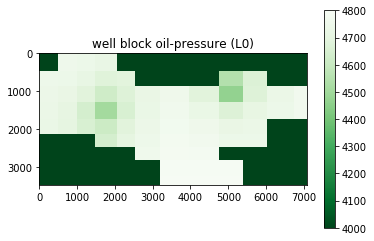

In [25]:
#Block pressure plot
import numpy as np
import matplotlib.pyplot as plt

cor = []

x_cor = 0

for ix in range (0,Nx):
    if ix == 0:
        x_cor += dx[iz,0,ix]/2    
    else:
        x_cor += dx[iz,0,ix-1]/2 + dx[iz,0,ix]/2
    y_cor = 0
    for iy in range (0,Ny):
        if iy == 0:
            y_cor += dy[iz,iy,0]/2  
            cor.append([x_cor,y_cor])
        else:
            y_cor += dy[iz,iy,0]/2 + dy[iz,iy-1,0]/2
            cor.append([x_cor,y_cor])
                
    
cor_array = np.array(cor)

pressure_L0 = []


for ix in range (0,Nx):
    for iy in range (0,Ny):
        pressure_L0.append(po[0,iy,ix])


pressure_array_L0 = np.array(pressure_L0)


grid_x, grid_y = np.mgrid[0:x_cor:100j, 0:y_cor:100j]

vmin_lower_limit = 4000
vmin_upper_limit = 4800


from scipy.interpolate import griddata
cmap = 'Greens_r'
grid_z0 = griddata(cor_array, pressure_array_L0, (grid_x, grid_y), method='nearest')

plt.imshow(grid_z0.T, extent=(0,x_cor,y_cor,0),vmin=vmin_lower_limit, vmax=vmin_upper_limit,cmap=cmap)
plt.title('well block oil-pressure (L0)')
plt.colorbar()
plt.show()

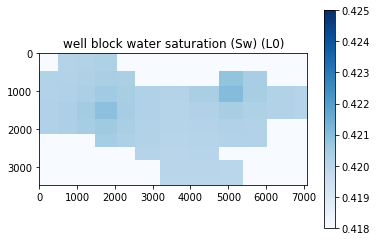

In [26]:
#Water saturation plot
import numpy as np
import matplotlib.pyplot as plt

cor = []

x_cor = 0

for ix in range (0,Nx):
    if ix == 0:
        x_cor += dx[iz,0,ix]/2    
    else:
        x_cor += dx[iz,0,ix-1]/2 + dx[iz,0,ix]/2
    y_cor = 0
    for iy in range (0,Ny):
        if iy == 0:
            y_cor += dy[iz,iy,0]/2  
            cor.append([x_cor,y_cor])
        else:
            y_cor += dy[iz,iy,0]/2 + dy[iz,iy-1,0]/2
            cor.append([x_cor,y_cor])
                
    
cor_array = np.array(cor)

water_saturation_L0 = []


for ix in range (0,Nx):
    for iy in range (0,Ny):
        water_saturation_L0.append(Sw[0,iy,ix])


water_saturation_array_L0 = np.array(water_saturation_L0)


grid_x, grid_y = np.mgrid[0:x_cor:100j, 0:y_cor:100j]

vmin_lower_limit = 0.418
vmin_upper_limit = 0.425


from scipy.interpolate import griddata
cmap = 'Blues'
grid_z0 = griddata(cor_array, water_saturation_array_L0, (grid_x, grid_y), method='nearest')

plt.imshow(grid_z0.T, extent=(0,x_cor,y_cor,0),vmin=vmin_lower_limit, vmax=vmin_upper_limit,cmap=cmap)
plt.title('well block water saturation (Sw) (L0)')
plt.colorbar()
plt.show()

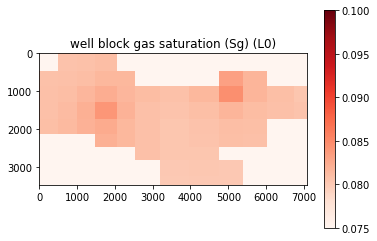

In [27]:
#Gas saturation plot
import numpy as np
import matplotlib.pyplot as plt

cor = []

x_cor = 0

for ix in range (0,Nx):
    if ix == 0:
        x_cor += dx[iz,0,ix]/2    
    else:
        x_cor += dx[iz,0,ix-1]/2 + dx[iz,0,ix]/2
    y_cor = 0
    for iy in range (0,Ny):
        if iy == 0:
            y_cor += dy[iz,iy,0]/2  
            cor.append([x_cor,y_cor])
        else:
            y_cor += dy[iz,iy,0]/2 + dy[iz,iy-1,0]/2
            cor.append([x_cor,y_cor])
                
    
cor_array = np.array(cor)

gas_saturation_L0 = []


for ix in range (0,Nx):
    for iy in range (0,Ny):
        gas_saturation_L0.append(Sg[0,iy,ix])


gas_saturation_array_L0 = np.array(gas_saturation_L0)


grid_x, grid_y = np.mgrid[0:x_cor:100j, 0:y_cor:100j]

vmin_lower_limit = 0.075
vmin_upper_limit = 0.10


from scipy.interpolate import griddata
cmap = 'Reds'
grid_z0 = griddata(cor_array, gas_saturation_array_L0, (grid_x, grid_y), method='nearest')

plt.imshow(grid_z0.T, extent=(0,x_cor,y_cor,0),vmin=vmin_lower_limit, vmax=vmin_upper_limit,cmap=cmap)
plt.title('well block gas saturation (Sg) (L0)')
plt.colorbar()
plt.show()

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Z contains NaN values. This may result in rendering artifacts.


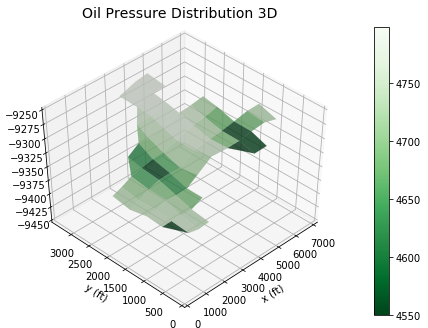

In [28]:
#Pressure Distribution (3D Map)

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x_array = []
y_array = []
z_array = []

iz = 0

x_cor = 0
for ix in range (0,Nx):
    if ix == 0:
        x_cor += dx[iz,0,ix]/2 
        x_array.append(x_cor)
    else:
        x_cor += dx[iz,0,ix-1]/2 + dx[iz,0,ix]/2
        x_array.append(x_cor)

y_cor = 0
for iy in range (0,Ny):
    if iy == 0:
        y_cor += dy[iz,iy,0]/2  
        y_array.append(y_cor)
    else:
        y_cor += dy[iz,iy,0]/2 + dy[iz,iy-1,0]/2
        y_array.append(y_cor)


for ix in range (0,Nx):
    for iy in range (0,Ny):
        z_array.append(middle[iz,iy,ix])


X, Y = np.meshgrid(x_array, y_array)
Z0 = -middle[iz,:,:]
pressure = po
Z0[abs(Z0)<1] = np.nan
    
fig = plt.figure()

ax = Axes3D(fig)
#ax = fig.add_subplot(111, projection='3d')
ax.view_init(45,45)
ax.set_xlim3d(abs(np.max(X)),0)
ax.set_ylim3d(abs(np.max(Y)),0)
ax.set_zlim3d(-9450,-9250)
# here we create the surface plot, but pass V through a colormap
# to create a different color for each patch
norm = matplotlib.colors.Normalize(vmin=4550, vmax=4800)
ax.plot_surface(X, Y, Z0, facecolors = cm.Greens_r(norm(pressure[iz,:,:])),linewidth=0.1,alpha = 0.8)


plt.title('Oil Pressure Distribution 3D',fontsize='14', y=1.1)
plt.xlabel('x (ft)')
plt.ylabel('y (ft)')

pressure_range = np.arange(4550,4800)
m = cm.ScalarMappable(cmap=cm.Greens_r)
m.set_array(pressure_range)
plt.colorbar(m)

fig.savefig('Po Map.png', dpi=500,bbox_inches = "tight")

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Z contains NaN values. This may result in rendering artifacts.


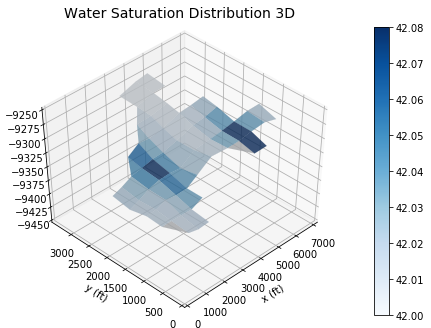

In [29]:
#water_saturation Distribution (3D Map)

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x_array = []
y_array = []
z_array = []

iz = 0

x_cor = 0
for ix in range (0,Nx):
    if ix == 0:
        x_cor += dx[iz,0,ix]/2 
        x_array.append(x_cor)
    else:
        x_cor += dx[iz,0,ix-1]/2 + dx[iz,0,ix]/2
        x_array.append(x_cor)

y_cor = 0
for iy in range (0,Ny):
    if iy == 0:
        y_cor += dy[iz,iy,0]/2  
        y_array.append(y_cor)
    else:
        y_cor += dy[iz,iy,0]/2 + dy[iz,iy-1,0]/2
        y_array.append(y_cor)


for ix in range (0,Nx):
    for iy in range (0,Ny):
        z_array.append(middle[iz,iy,ix])


X, Y = np.meshgrid(x_array, y_array)
Z0 = -middle[iz,:,:]
water_saturation = Sw*100
Z0[abs(Z0)<1] = np.nan
    
fig = plt.figure()

ax = Axes3D(fig)
#ax = fig.add_subplot(111, projection='3d')
ax.view_init(45,45)
ax.set_xlim3d(abs(np.max(X)),0)
ax.set_ylim3d(abs(np.max(Y)),0)
ax.set_zlim3d(-9450,-9250)
# here we create the surface plot, but pass V through a colormap
# to create a different color for each patch
norm = matplotlib.colors.Normalize(vmin=42, vmax=42.08)
ax.plot_surface(X, Y, Z0, facecolors = cm.Blues(norm(water_saturation[iz,:,:])),linewidth=0.1,alpha = 0.8)


plt.title('Water Saturation Distribution 3D',fontsize='14', y=1.1)
plt.xlabel('x (ft)')
plt.ylabel('y (ft)')

water_saturation_range = np.linspace(42,42.08,8)
m = cm.ScalarMappable(cmap=cm.Blues)
m.set_array(water_saturation_range)
plt.colorbar(m)

fig.savefig('Sw Map.png', dpi=500,bbox_inches = "tight")

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Z contains NaN values. This may result in rendering artifacts.


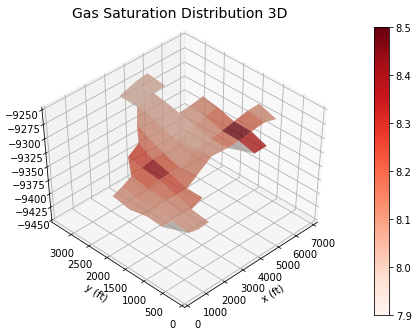

In [30]:
#gas_saturation Distribution (3D Map)

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x_array = []
y_array = []
z_array = []

iz = 0

x_cor = 0
for ix in range (0,Nx):
    if ix == 0:
        x_cor += dx[iz,0,ix]/2 
        x_array.append(x_cor)
    else:
        x_cor += dx[iz,0,ix-1]/2 + dx[iz,0,ix]/2
        x_array.append(x_cor)

y_cor = 0
for iy in range (0,Ny):
    if iy == 0:
        y_cor += dy[iz,iy,0]/2  
        y_array.append(y_cor)
    else:
        y_cor += dy[iz,iy,0]/2 + dy[iz,iy-1,0]/2
        y_array.append(y_cor)


for ix in range (0,Nx):
    for iy in range (0,Ny):
        z_array.append(middle[iz,iy,ix])


X, Y = np.meshgrid(x_array, y_array)
Z0 = -middle[iz,:,:]
gas_saturation = Sg*100
Z0[abs(Z0)<1] = np.nan
    
fig = plt.figure()

ax = Axes3D(fig)
#ax = fig.add_subplot(111, projection='3d')
ax.view_init(45,45)
ax.set_xlim3d(abs(np.max(X)),0)
ax.set_ylim3d(abs(np.max(Y)),0)
ax.set_zlim3d(-9450,-9250)
# here we create the surface plot, but pass V through a colormap
# to create a different color for each patch
norm = matplotlib.colors.Normalize(vmin=7.9, vmax=8.5)
ax.plot_surface(X, Y, Z0, facecolors = cm.Reds(norm(gas_saturation[iz,:,:])),linewidth=0.1,alpha = 0.8)


plt.title('Gas Saturation Distribution 3D',fontsize='14', y=1.1)
plt.xlabel('x (ft)')
plt.ylabel('y (ft)')

gas_saturation_range = np.linspace(7.9,8.5,6)
m = cm.ScalarMappable(cmap=cm.Reds)
m.set_array(gas_saturation_range)
plt.colorbar(m)

fig.savefig('Sg Map.png', dpi=500,bbox_inches = "tight")